In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from tqdm.notebook import tqdm, trange
from sk_models import setup_pls_models_exh, StandardScaler, PLSRegression, CustomWrapper

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)

In [2]:
#set up some stuff to manage metadata for each dataset
id_col_db = {'A_C_OF_ALPHA':["sample_id"],
             'A_C_OF_SIWARE':[],
             'A_AL_RT':[],
             'PLN7':["db_id", "sample_id"],
             'mango_684_990': ['Set','Season','Region','Date','Type','Cultivar','Pop','Temp',"FruitID"]
            }

output_col_db= {'A_C_OF_ALPHA':None,
             'A_C_OF_SIWARE':None,
             'A_AL_RT':None,
             'PLN7':None,
             'mango_684_990': ['DM']
            }


In [3]:
#setup input and output formats, load data

file_name = "mango_684_990.csv"
dataset_name = re.sub(r'\.(?=csv$)[^.]+$', '',file_name)



data_path = Path('D:/workspace/lazydeep/data/soil_data/')
model_path = Path('D:/workspace/lazydeep/experiments/1.01/')
log_path = Path("D:/workspace/lazydeep/experiments/1.04")
n_components = 59

data_file = data_path / file_name
log_dir = log_path / dataset_name
model_dir = model_path / dataset_name

if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)

id_cols =id_col_db[dataset_name]
output_cols = output_col_db[dataset_name]


D:\workspace\lazydeep\experiments\1.04\mango_684_990


In [4]:
data = pd.read_csv(data_file)
if not file_name == 'mango_684_990.csv': 
    data = data.sample(frac=1)
nrow, ncol = data.shape
data = ut.sample_data(data,random_state)
n_features = ncol - 1-len(id_cols)
dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
#dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=None, ignore_cols= None)


In [5]:
n_models = 100

model_names = [f"random_{i}" for i in range(0,n_models)]
deep_models = {name:torch.load(model_dir/"models"/name/"_model") for name in model_names}
#for each model, load state
print(f"Loaded {len(deep_models)} models")

#print(deep_models)
for name in model_names:
    sub_path = log_dir / name
    if not sub_path.exists():
        sub_path.mkdir()

Loaded 100 models


In [6]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
tb = SummaryWriter(log_dir/"tb")

In [7]:
fixed_hyperparams = {'bs': 32,'loss': nn.MSELoss(),'epochs': 100}
preprocessing = PLSRegression(n_components=n_components)

if dataset_name == 'mango_684_990':
    eval_ = MangoesSplitter(preprocessing=preprocessing,tensorboard=None,time=True,random_state=random_state)
else:
    eval_ = CrossValEvaluation(preprocessing=preprocessing,tensorboard=None,time=True,random_state=random_state)
    
print(f"Dataset shape is {data.shape}")
scores={} #->model->knn:{fold_0:number,...,fold_n:number,mean:number,median:number
preds={} #model-> foldsxknn_models
deep_scores_dict={}
deep_preds_dict={}
actual_y = None

device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_fun_cv = lambda name,model, fold : model.load_state(model_dir/'models'/name/f"_fold_{fold}")
load_fun_pp_cv = lambda fold : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_fold_{fold}"))
load_fun_build = lambda name,model : model.load_state(model_dir/'models'/name/f"_final")
load_fun_pp_build = lambda : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_final"))

Dataset shape is (11691, 113)


In [8]:
deep_scheme = DeepScheme(None, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=True,update=False)
deep_scores, deep_preds, _ , _, _,_ = eval_.evaluate(deep_models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp = load_fun_pp_cv)
deep_scores_final, deep_preds_final, _ ,_, _,_ = eval_.build(deep_models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp = load_fun_pp_build)

all_scores = []
for k,v in ut.flip_dicts(deep_scores).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores.append({**dict1,**v})
    
all_scores_final = []
for k,v in ut.flip_dicts(deep_scores_final).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores_final.append({**dict1,**v})

Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Tested (test) on 1905 instances with mean losses of: random_0:0.8233,random_1:0.807,random_2:0.6161,random_3:264.4626,random_4:0.8111,random_5:0.5017,random_6:271.8982,random_7:0.5023,random_8:0.5081,random_9:0.9613,random_10:0.7669,random_11:0.5153,random_12:0.5384,random_13:0.7874,random_14:6.1302,random_15:0.975,random_16:0.5693,random_17:1.1252,random_18:0.5785,random_19:0.5572,random_20:0.8867,random_21:0.4698,random_22:0.9858,random_23:0.7741,random_24:0.8587,random_25:0.7535,random_26:0.5371,random_27:0.8033,random_28:0.8394,random_29:0.7193,random_30:0.562,random_31:0.9906,random_32:0.6003,random_33:273.8991,random_34:0.7762,random_35:0.7732,random_36:0.8258,random_37:0.9836,random_38:6.1238,random_39:0.6793,random_40:0.7944,random_41:0.5056,random_42:0.5355,random_43:0.7195,random_44:0.8293,random_45:280.2945,random_46:0.9234,

In [9]:
scores_df_sorted = pd.DataFrame(all_scores).sort_values(by='MSE')

for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    print(s)

0 - random_59 - deep - 0.41344394868440204 - 0.4268353875640713 - 0.38668853449156804 - 0.4572330106437476 - 0.45067953918038345 - 0.42715798708023967 - 0.9296530954646005
1 - random_21 - deep - 0.46982851644826373 - 0.4829046178351888 - 0.4421578718634937 - 0.5073498061939122 - 0.48945786849971135 - 0.47852009789036615 - 0.9211944791793387
2 - random_82 - deep - 0.4732125640228352 - 0.4900174628743125 - 0.4473183443082259 - 0.5129462654654137 - 0.49000114415925466 - 0.4828983874404394 - 0.9204734365526689
3 - random_77 - deep - 0.4860427215969156 - 0.4911194901332221 - 0.43916691134255387 - 0.5363065382234411 - 0.5134993734357267 - 0.49345653250734556 - 0.9187346587571994
4 - random_5 - deep - 0.5017142913316491 - 0.48238601705912126 - 0.45223166167766826 - 0.5203985189180867 - 0.5261903511747895 - 0.4966379684436345 - 0.9182107210646717
5 - random_32 - deep - 0.6002785096018333 - 0.47158061427533476 - 0.41952084913411336 - 0.5031710790293249 - 0.4923633533434727 - 0.49703222356799426

In [10]:
def build_predictors(n):
    predictors = {}
    for i in [5,10,20,50,100,200,500,1000]:
        if i* 2 < n:
            predictors[f'knn_unif_n={i}'] = CustomWrapper(KNeighborsRegressor(n_neighbors=i, weights='uniform'))
            predictors[f'knn_dist_n={i}'] = CustomWrapper(KNeighborsRegressor(n_neighbors=i, weights='distance'))
    return predictors

for deep_name,deep_model in tqdm(deep_models.items()):
    logging.getLogger().info(f"Running model {deep_name}")
    temp_dict = {deep_name:deep_model}

    lwr_scheme = DeepLWRScheme_1_to_n(lwr_models = build_predictors(nrow),n_neighbours=500,loss_fun_sk = mean_squared_error)
    lwr_scores, lwr_preds, _ , _, _,_= eval_.evaluate(temp_dict,dataset,lwr_scheme,logger_name="log")
    lwr_scores_final, lwr_preds_final, _ , _, _,_= eval_.build(temp_dict,dataset,lwr_scheme,logger_name="test_log")

    #scores
    for k,v in ut.flip_dicts(lwr_scores).items():
        dict1 = {'model_num':deep_name,"predictor":k}
        all_scores.append({**dict1,**v})

    for k,v in ut.flip_dicts(lwr_scores_final).items():
        dict1 = {'model_num':deep_name,"predictor":k}
        all_scores_final.append({**dict1,**v})

    lwr_preds['deep'] = deep_preds[deep_name]
    lwr_preds_final['deep'] = deep_preds_final[deep_name]

    lwr_preds.to_csv(log_dir/deep_name/ f"predictions.csv",index=False)
    lwr_preds_final.to_csv(log_dir/deep_name/ f"predictions_test.csv",index=False)

    #preds
    # todo save predictions - appending solns
    plot_preds_and_res(lwr_preds,name_lambda=lambda x:f"{deep_name} with {x} predictor",save_lambda= lambda x:f"deep_lwr{x}",save_loc=log_dir/deep_name)

  0%|          | 0/100 [00:00<?, ?it/s]

Running model random_0'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4686,knn_dist_n=5:0.0,knn_unif_n=10:0.5813,knn_dist_n=10:0.0,knn_unif_n=20:0.6474,knn_dist_n=20:0.0,knn_unif_n=50:0.7085,knn_dist_n=50:0.0,knn_unif_n=100:0.7357,knn_dist_n=100:0.0,knn_unif_n=200:0.7602,knn_dist_n=200:0.0,knn_unif_n=500:0.8167,knn_dist_n=500:0.0,knn_unif_n=1000:0.9093,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.736,knn_dist_n=5:0.6635,knn_unif_n=10:0.715,knn_dist_n=10:0.6507,knn_unif_n=20:0.712,knn_dist_n=20:0.6567,knn_unif_n=50:0.7278,knn_dist_n=50:0.6847,knn_unif_n=100:0.7481,knn_dist_n=100:0.712,knn_unif_n=200:0.7664,knn_dist_n=200:0.7364,knn_unif_n=500:0.8262,knn_dist_n=500:0.7894,knn_unif_n=1000:0.9202,knn_dist_n=1000:0.8569'
-----------------------------------Fold 1 - Train 5855 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_1'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5113,knn_dist_n=5:0.0,knn_unif_n=10:0.5955,knn_dist_n=10:0.0,knn_unif_n=20:0.6433,knn_dist_n=20:0.0,knn_unif_n=50:0.6946,knn_dist_n=50:0.0,knn_unif_n=100:0.7232,knn_dist_n=100:0.0,knn_unif_n=200:0.7498,knn_dist_n=200:0.0,knn_unif_n=500:0.8056,knn_dist_n=500:0.0,knn_unif_n=1000:0.896,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7607,knn_dist_n=5:0.7529,knn_unif_n=10:0.7117,knn_dist_n=10:0.7004,knn_unif_n=20:0.6903,knn_dist_n=20:0.6784,knn_unif_n=50:0.6933,knn_dist_n=50:0.6776,knn_unif_n=100:0.7169,knn_dist_n=100:0.6948,knn_unif_n=200:0.7434,knn_dist_n=200:0.7143,knn_unif_n=500:0.8017,knn_dist_n=500:0.7493,knn_unif_n=1000:0.8934,knn_dist_n=1000:0.7934'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_2'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5157,knn_dist_n=5:0.0,knn_unif_n=10:0.6006,knn_dist_n=10:0.0,knn_unif_n=20:0.6553,knn_dist_n=20:0.0,knn_unif_n=50:0.6942,knn_dist_n=50:0.0,knn_unif_n=100:0.7145,knn_dist_n=100:0.0,knn_unif_n=200:0.7402,knn_dist_n=200:0.0,knn_unif_n=500:0.8045,knn_dist_n=500:0.0,knn_unif_n=1000:0.9113,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8056,knn_dist_n=5:0.7952,knn_unif_n=10:0.7494,knn_dist_n=10:0.7396,knn_unif_n=20:0.7243,knn_dist_n=20:0.7146,knn_unif_n=50:0.7294,knn_dist_n=50:0.7173,knn_unif_n=100:0.7503,knn_dist_n=100:0.7341,knn_unif_n=200:0.7694,knn_dist_n=200:0.7505,knn_unif_n=500:0.8282,knn_dist_n=500:0.7921,knn_unif_n=1000:0.9322,knn_dist_n=1000:0.8572'
-----------------------------------Fold 1 - Train 5855 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_3'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5097,knn_dist_n=5:0.0,knn_unif_n=10:0.6257,knn_dist_n=10:0.0,knn_unif_n=20:0.7178,knn_dist_n=20:0.0,knn_unif_n=50:0.8353,knn_dist_n=50:0.0,knn_unif_n=100:0.9522,knn_dist_n=100:0.0,knn_unif_n=200:1.1409,knn_dist_n=200:0.0,knn_unif_n=500:1.6775,knn_dist_n=500:0.0,knn_unif_n=1000:2.5561,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8006,knn_dist_n=5:0.6829,knn_unif_n=10:0.7997,knn_dist_n=10:0.6945,knn_unif_n=20:0.8058,knn_dist_n=20:0.7158,knn_unif_n=50:0.8616,knn_dist_n=50:0.7765,knn_unif_n=100:0.9693,knn_dist_n=100:0.8702,knn_unif_n=200:1.15,knn_dist_n=200:1.0157,knn_unif_n=500:1.687,knn_dist_n=500:1.3993,knn_unif_n=1000:2.5656,knn_dist_n=1000:1.9855'
-----------------------------------Fold 1 - Train 5855 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_4'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.531,knn_dist_n=5:0.0,knn_unif_n=10:0.6622,knn_dist_n=10:0.0,knn_unif_n=20:0.7414,knn_dist_n=20:0.0,knn_unif_n=50:0.8064,knn_dist_n=50:0.0,knn_unif_n=100:0.8551,knn_dist_n=100:0.0,knn_unif_n=200:0.899,knn_dist_n=200:0.0,knn_unif_n=500:0.9861,knn_dist_n=500:0.0,knn_unif_n=1000:1.1154,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8519,knn_dist_n=5:0.7614,knn_unif_n=10:0.8317,knn_dist_n=10:0.7482,knn_unif_n=20:0.8167,knn_dist_n=20:0.7495,knn_unif_n=50:0.835,knn_dist_n=50:0.78,knn_unif_n=100:0.8777,knn_dist_n=100:0.8238,knn_unif_n=200:0.9178,knn_dist_n=200:0.8656,knn_unif_n=500:1.0006,knn_dist_n=500:0.9392,knn_unif_n=1000:1.1308,knn_dist_n=1000:1.0362'
-----------------------------------Fold 1 - Train 5855 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_5'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4966,knn_dist_n=5:0.0,knn_unif_n=10:0.5721,knn_dist_n=10:0.0,knn_unif_n=20:0.6123,knn_dist_n=20:0.0,knn_unif_n=50:0.6412,knn_dist_n=50:0.0,knn_unif_n=100:0.6615,knn_dist_n=100:0.0,knn_unif_n=200:0.6887,knn_dist_n=200:0.0,knn_unif_n=500:0.753,knn_dist_n=500:0.0,knn_unif_n=1000:0.8792,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7651,knn_dist_n=5:0.7662,knn_unif_n=10:0.7225,knn_dist_n=10:0.7183,knn_unif_n=20:0.6982,knn_dist_n=20:0.694,knn_unif_n=50:0.6819,knn_dist_n=50:0.6778,knn_unif_n=100:0.6824,knn_dist_n=100:0.676,knn_unif_n=200:0.6959,knn_dist_n=200:0.6819,knn_unif_n=500:0.7559,knn_dist_n=500:0.7133,knn_unif_n=1000:0.8868,knn_dist_n=1000:0.7826'
-----------------------------------Fold 1 - Train 5855 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_6'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:2.0475,knn_dist_n=5:0.0,knn_unif_n=10:2.7621,knn_dist_n=10:0.0,knn_unif_n=20:3.3358,knn_dist_n=20:0.0,knn_unif_n=50:3.9497,knn_dist_n=50:0.0,knn_unif_n=100:4.3693,knn_dist_n=100:0.0,knn_unif_n=200:4.7712,knn_dist_n=200:0.0,knn_unif_n=500:5.2883,knn_dist_n=500:0.0,knn_unif_n=1000:5.6346,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:3.1084,knn_dist_n=5:2.2374,knn_unif_n=10:3.3267,knn_dist_n=10:2.416,knn_unif_n=20:3.5789,knn_dist_n=20:2.732,knn_unif_n=50:4.0179,knn_dist_n=50:3.3203,knn_unif_n=100:4.3523,knn_dist_n=100:3.7646,knn_unif_n=200:4.7229,knn_dist_n=200:4.2099,knn_unif_n=500:5.224,knn_dist_n=500:4.7837,knn_unif_n=1000:5.609,knn_dist_n=1000:5.2004'
-----------------------------------Fold 1 - Train 5855 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_7'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5087,knn_dist_n=5:0.0,knn_unif_n=10:0.585,knn_dist_n=10:0.0,knn_unif_n=20:0.6122,knn_dist_n=20:0.0,knn_unif_n=50:0.6365,knn_dist_n=50:0.0,knn_unif_n=100:0.6462,knn_dist_n=100:0.0,knn_unif_n=200:0.6586,knn_dist_n=200:0.0,knn_unif_n=500:0.7052,knn_dist_n=500:0.0,knn_unif_n=1000:0.8011,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7667,knn_dist_n=5:0.781,knn_unif_n=10:0.7035,knn_dist_n=10:0.7147,knn_unif_n=20:0.6723,knn_dist_n=20:0.6803,knn_unif_n=50:0.6623,knn_dist_n=50:0.6629,knn_unif_n=100:0.6549,knn_dist_n=100:0.6549,knn_unif_n=200:0.6647,knn_dist_n=200:0.6554,knn_unif_n=500:0.7091,knn_dist_n=500:0.6664,knn_unif_n=1000:0.8073,knn_dist_n=1000:0.6939'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_8'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4313,knn_dist_n=5:0.0,knn_unif_n=10:0.5034,knn_dist_n=10:0.0,knn_unif_n=20:0.5502,knn_dist_n=20:0.0,knn_unif_n=50:0.5808,knn_dist_n=50:0.0,knn_unif_n=100:0.5992,knn_dist_n=100:0.0,knn_unif_n=200:0.6211,knn_dist_n=200:0.0,knn_unif_n=500:0.6696,knn_dist_n=500:0.0,knn_unif_n=1000:0.7758,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.6473,knn_dist_n=5:0.6293,knn_unif_n=10:0.6247,knn_dist_n=10:0.6066,knn_unif_n=20:0.6222,knn_dist_n=20:0.6062,knn_unif_n=50:0.6193,knn_dist_n=50:0.6078,knn_unif_n=100:0.6223,knn_dist_n=100:0.6126,knn_unif_n=200:0.6363,knn_dist_n=200:0.6225,knn_unif_n=500:0.6827,knn_dist_n=500:0.6506,knn_unif_n=1000:0.7907,knn_dist_n=1000:0.7075'
-----------------------------------Fold 1 - Train 5855 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_9'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.429,knn_dist_n=5:0.0,knn_unif_n=10:0.5527,knn_dist_n=10:0.0,knn_unif_n=20:0.6395,knn_dist_n=20:0.0,knn_unif_n=50:0.7432,knn_dist_n=50:0.0,knn_unif_n=100:0.8289,knn_dist_n=100:0.0,knn_unif_n=200:0.9373,knn_dist_n=200:0.0,knn_unif_n=500:1.1723,knn_dist_n=500:0.0,knn_unif_n=1000:1.5091,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.6838,knn_dist_n=5:0.5306,knn_unif_n=10:0.673,knn_dist_n=10:0.5331,knn_unif_n=20:0.6955,knn_dist_n=20:0.5713,knn_unif_n=50:0.7744,knn_dist_n=50:0.6696,knn_unif_n=100:0.8365,knn_dist_n=100:0.7461,knn_unif_n=200:0.9407,knn_dist_n=200:0.8498,knn_unif_n=500:1.1817,knn_dist_n=500:1.0622,knn_unif_n=1000:1.5324,knn_dist_n=1000:1.344'
-----------------------------------Fold 1 - Train 5855 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_10'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4704,knn_dist_n=5:0.0,knn_unif_n=10:0.5664,knn_dist_n=10:0.0,knn_unif_n=20:0.6175,knn_dist_n=20:0.0,knn_unif_n=50:0.6626,knn_dist_n=50:0.0,knn_unif_n=100:0.6968,knn_dist_n=100:0.0,knn_unif_n=200:0.7341,knn_dist_n=200:0.0,knn_unif_n=500:0.8308,knn_dist_n=500:0.0,knn_unif_n=1000:0.9891,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7261,knn_dist_n=5:0.6783,knn_unif_n=10:0.6975,knn_dist_n=10:0.6508,knn_unif_n=20:0.6786,knn_dist_n=20:0.6393,knn_unif_n=50:0.677,knn_dist_n=50:0.6446,knn_unif_n=100:0.6952,knn_dist_n=100:0.663,knn_unif_n=200:0.7259,knn_dist_n=200:0.6885,knn_unif_n=500:0.8132,knn_dist_n=500:0.7501,knn_unif_n=1000:0.968,knn_dist_n=1000:0.8508'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_11'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4334,knn_dist_n=5:0.0,knn_unif_n=10:0.5204,knn_dist_n=10:0.0,knn_unif_n=20:0.5741,knn_dist_n=20:0.0,knn_unif_n=50:0.636,knn_dist_n=50:0.0,knn_unif_n=100:0.6782,knn_dist_n=100:0.0,knn_unif_n=200:0.7245,knn_dist_n=200:0.0,knn_unif_n=500:0.8202,knn_dist_n=500:0.0,knn_unif_n=1000:0.98,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.6563,knn_dist_n=5:0.625,knn_unif_n=10:0.6564,knn_dist_n=10:0.6285,knn_unif_n=20:0.6663,knn_dist_n=20:0.6415,knn_unif_n=50:0.6833,knn_dist_n=50:0.6631,knn_unif_n=100:0.7062,knn_dist_n=100:0.6868,knn_unif_n=200:0.7456,knn_dist_n=200:0.7236,knn_unif_n=500:0.8451,knn_dist_n=500:0.8082,knn_unif_n=1000:1.0167,knn_dist_n=1000:0.9441'
-----------------------------------Fold 1 - Train 5855 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_12'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5549,knn_dist_n=5:0.0817,knn_unif_n=10:0.633,knn_dist_n=10:0.0804,knn_unif_n=20:0.6728,knn_dist_n=20:0.0832,knn_unif_n=50:0.7078,knn_dist_n=50:0.0811,knn_unif_n=100:0.7336,knn_dist_n=100:0.0813,knn_unif_n=200:0.753,knn_dist_n=200:0.0806,knn_unif_n=500:0.7963,knn_dist_n=500:0.0804,knn_unif_n=1000:0.8784,knn_dist_n=1000:0.0804'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8082,knn_dist_n=5:0.8003,knn_unif_n=10:0.7685,knn_dist_n=10:0.7579,knn_unif_n=20:0.7458,knn_dist_n=20:0.7366,knn_unif_n=50:0.7369,knn_dist_n=50:0.7259,knn_unif_n=100:0.7472,knn_dist_n=100:0.7321,knn_unif_n=200:0.7589,knn_dist_n=200:0.7398,knn_unif_n=500:0.7901,knn_dist_n=500:0.7613,knn_unif_n=1000:0.8728,knn_dist_n=1000:0.7972'
----------------------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_13'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5384,knn_dist_n=5:0.0,knn_unif_n=10:0.6153,knn_dist_n=10:0.0,knn_unif_n=20:0.6717,knn_dist_n=20:0.0,knn_unif_n=50:0.7138,knn_dist_n=50:0.0,knn_unif_n=100:0.7361,knn_dist_n=100:0.0,knn_unif_n=200:0.7621,knn_dist_n=200:0.0,knn_unif_n=500:0.822,knn_dist_n=500:0.0,knn_unif_n=1000:0.924,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7577,knn_dist_n=5:0.7371,knn_unif_n=10:0.728,knn_dist_n=10:0.7009,knn_unif_n=20:0.7204,knn_dist_n=20:0.6902,knn_unif_n=50:0.731,knn_dist_n=50:0.7005,knn_unif_n=100:0.7487,knn_dist_n=100:0.7172,knn_unif_n=200:0.7689,knn_dist_n=200:0.7358,knn_unif_n=500:0.8277,knn_dist_n=500:0.7766,knn_unif_n=1000:0.9306,knn_dist_n=1000:0.8335'
-----------------------------------Fold 1 - Train 5855 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_14'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:6.9183,knn_dist_n=5:6.9183,knn_unif_n=10:6.2737,knn_dist_n=10:6.2737,knn_unif_n=20:6.2573,knn_dist_n=20:6.2573,knn_unif_n=50:6.1632,knn_dist_n=50:6.1632,knn_unif_n=100:6.148,knn_dist_n=100:6.148,knn_unif_n=200:6.151,knn_dist_n=200:6.151,knn_unif_n=500:6.1822,knn_dist_n=500:6.1822,knn_unif_n=1000:6.1644,knn_dist_n=1000:6.1644'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:6.7421,knn_dist_n=5:6.7421,knn_unif_n=10:6.329,knn_dist_n=10:6.329,knn_unif_n=20:6.3082,knn_dist_n=20:6.3082,knn_unif_n=50:6.1255,knn_dist_n=50:6.1255,knn_unif_n=100:6.1477,knn_dist_n=100:6.1477,knn_unif_n=200:6.1545,knn_dist_n=200:6.1545,knn_unif_n=500:6.2067,knn_dist_n=500:6.2067,knn_unif_n=1000:6.1792,knn_dist_n=1000:6.1792'
-----------------------------------Fol

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_15'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4338,knn_dist_n=5:0.0,knn_unif_n=10:0.5458,knn_dist_n=10:0.0,knn_unif_n=20:0.6248,knn_dist_n=20:0.0,knn_unif_n=50:0.6948,knn_dist_n=50:0.0,knn_unif_n=100:0.7377,knn_dist_n=100:0.0,knn_unif_n=200:0.7831,knn_dist_n=200:0.0,knn_unif_n=500:0.8515,knn_dist_n=500:0.0,knn_unif_n=1000:0.949,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.6747,knn_dist_n=5:0.5891,knn_unif_n=10:0.6756,knn_dist_n=10:0.5992,knn_unif_n=20:0.6924,knn_dist_n=20:0.6271,knn_unif_n=50:0.7177,knn_dist_n=50:0.6678,knn_unif_n=100:0.7507,knn_dist_n=100:0.7072,knn_unif_n=200:0.7908,knn_dist_n=200:0.7463,knn_unif_n=500:0.8543,knn_dist_n=500:0.8064,knn_unif_n=1000:0.956,knn_dist_n=1000:0.8847'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_16'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.636,knn_dist_n=5:0.0654,knn_unif_n=10:0.6999,knn_dist_n=10:0.0638,knn_unif_n=20:0.7321,knn_dist_n=20:0.0616,knn_unif_n=50:0.7546,knn_dist_n=50:0.0631,knn_unif_n=100:0.7607,knn_dist_n=100:0.0616,knn_unif_n=200:0.7699,knn_dist_n=200:0.0617,knn_unif_n=500:0.7985,knn_dist_n=500:0.0614,knn_unif_n=1000:0.8901,knn_dist_n=1000:0.0614'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.9123,knn_dist_n=5:1.0676,knn_unif_n=10:0.8557,knn_dist_n=10:1.0118,knn_unif_n=20:0.806,knn_dist_n=20:0.9687,knn_unif_n=50:0.784,knn_dist_n=50:0.9362,knn_unif_n=100:0.7788,knn_dist_n=100:0.9172,knn_unif_n=200:0.7827,knn_dist_n=200:0.9047,knn_unif_n=500:0.8034,knn_dist_n=500:0.8935,knn_unif_n=1000:0.8908,knn_dist_n=1000:0.8925'
-----------------------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_17'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4844,knn_dist_n=5:0.0,knn_unif_n=10:0.6162,knn_dist_n=10:0.0,knn_unif_n=20:0.7107,knn_dist_n=20:0.0,knn_unif_n=50:0.8418,knn_dist_n=50:0.0,knn_unif_n=100:0.99,knn_dist_n=100:0.0,knn_unif_n=200:1.1988,knn_dist_n=200:0.0,knn_unif_n=500:1.6716,knn_dist_n=500:0.0,knn_unif_n=1000:2.3245,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.6998,knn_dist_n=5:0.5751,knn_unif_n=10:0.7013,knn_dist_n=10:0.5807,knn_unif_n=20:0.7384,knn_dist_n=20:0.6252,knn_unif_n=50:0.8415,knn_dist_n=50:0.7322,knn_unif_n=100:0.9821,knn_dist_n=100:0.8602,knn_unif_n=200:1.1863,knn_dist_n=200:1.0394,knn_unif_n=500:1.6556,knn_dist_n=500:1.4218,knn_unif_n=1000:2.3025,knn_dist_n=1000:1.9079'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_18'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5309,knn_dist_n=5:0.0,knn_unif_n=10:0.6158,knn_dist_n=10:0.0,knn_unif_n=20:0.6726,knn_dist_n=20:0.0,knn_unif_n=50:0.7104,knn_dist_n=50:0.0,knn_unif_n=100:0.7311,knn_dist_n=100:0.0,knn_unif_n=200:0.7515,knn_dist_n=200:0.0,knn_unif_n=500:0.8032,knn_dist_n=500:0.0,knn_unif_n=1000:0.902,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8102,knn_dist_n=5:0.801,knn_unif_n=10:0.7458,knn_dist_n=10:0.7382,knn_unif_n=20:0.7263,knn_dist_n=20:0.7174,knn_unif_n=50:0.7221,knn_dist_n=50:0.7121,knn_unif_n=100:0.7228,knn_dist_n=100:0.7131,knn_unif_n=200:0.7348,knn_dist_n=200:0.7225,knn_unif_n=500:0.7859,knn_dist_n=500:0.7552,knn_unif_n=1000:0.8866,knn_dist_n=1000:0.8089'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_19'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.6767,knn_dist_n=5:0.1617,knn_unif_n=10:0.6859,knn_dist_n=10:0.1082,knn_unif_n=20:0.7213,knn_dist_n=20:0.1114,knn_unif_n=50:0.7303,knn_dist_n=50:0.1022,knn_unif_n=100:0.7378,knn_dist_n=100:0.1013,knn_unif_n=200:0.7486,knn_dist_n=200:0.1013,knn_unif_n=500:0.7778,knn_dist_n=500:0.1012,knn_unif_n=1000:0.8506,knn_dist_n=1000:0.1012'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8857,knn_dist_n=5:0.9986,knn_unif_n=10:0.7717,knn_dist_n=10:0.8909,knn_unif_n=20:0.7492,knn_dist_n=20:0.8617,knn_unif_n=50:0.7334,knn_dist_n=50:0.8289,knn_unif_n=100:0.7314,knn_dist_n=100:0.8167,knn_unif_n=200:0.7383,knn_dist_n=200:0.8107,knn_unif_n=500:0.7645,knn_dist_n=500:0.8103,knn_unif_n=1000:0.8363,knn_dist_n=1000:0.8183'
--------------------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_20'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5279,knn_dist_n=5:0.0,knn_unif_n=10:0.6161,knn_dist_n=10:0.0,knn_unif_n=20:0.677,knn_dist_n=20:0.0,knn_unif_n=50:0.723,knn_dist_n=50:0.0,knn_unif_n=100:0.7459,knn_dist_n=100:0.0,knn_unif_n=200:0.7739,knn_dist_n=200:0.0,knn_unif_n=500:0.8338,knn_dist_n=500:0.0,knn_unif_n=1000:0.9259,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7908,knn_dist_n=5:0.7605,knn_unif_n=10:0.7517,knn_dist_n=10:0.7236,knn_unif_n=20:0.7494,knn_dist_n=20:0.7215,knn_unif_n=50:0.7476,knn_dist_n=50:0.7256,knn_unif_n=100:0.7587,knn_dist_n=100:0.738,knn_unif_n=200:0.7816,knn_dist_n=200:0.7572,knn_unif_n=500:0.8383,knn_dist_n=500:0.7947,knn_unif_n=1000:0.9309,knn_dist_n=1000:0.8452'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_21'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5693,knn_dist_n=5:0.0038,knn_unif_n=10:0.6374,knn_dist_n=10:0.0026,knn_unif_n=20:0.6757,knn_dist_n=20:0.0025,knn_unif_n=50:0.6971,knn_dist_n=50:0.0025,knn_unif_n=100:0.7101,knn_dist_n=100:0.0025,knn_unif_n=200:0.7253,knn_dist_n=200:0.0025,knn_unif_n=500:0.7656,knn_dist_n=500:0.0025,knn_unif_n=1000:0.8597,knn_dist_n=1000:0.0025'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8809,knn_dist_n=5:1.0093,knn_unif_n=10:0.8064,knn_dist_n=10:0.9362,knn_unif_n=20:0.7615,knn_dist_n=20:0.8921,knn_unif_n=50:0.7398,knn_dist_n=50:0.8552,knn_unif_n=100:0.7374,knn_dist_n=100:0.8383,knn_unif_n=200:0.7491,knn_dist_n=200:0.8276,knn_unif_n=500:0.788,knn_dist_n=500:0.8196,knn_unif_n=1000:0.8824,knn_dist_n=1000:0.8265'
---------------------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_22'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4741,knn_dist_n=5:0.0,knn_unif_n=10:0.5713,knn_dist_n=10:0.0,knn_unif_n=20:0.6455,knn_dist_n=20:0.0,knn_unif_n=50:0.6983,knn_dist_n=50:0.0,knn_unif_n=100:0.7369,knn_dist_n=100:0.0,knn_unif_n=200:0.7843,knn_dist_n=200:0.0,knn_unif_n=500:0.9093,knn_dist_n=500:0.0,knn_unif_n=1000:1.126,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7377,knn_dist_n=5:0.6976,knn_unif_n=10:0.7176,knn_dist_n=10:0.6703,knn_unif_n=20:0.7003,knn_dist_n=20:0.6601,knn_unif_n=50:0.7131,knn_dist_n=50:0.6759,knn_unif_n=100:0.7365,knn_dist_n=100:0.6985,knn_unif_n=200:0.7794,knn_dist_n=200:0.734,knn_unif_n=500:0.905,knn_dist_n=500:0.8238,knn_unif_n=1000:1.1231,knn_dist_n=1000:0.9691'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_23'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4741,knn_dist_n=5:0.0,knn_unif_n=10:0.6029,knn_dist_n=10:0.0,knn_unif_n=20:0.6794,knn_dist_n=20:0.0,knn_unif_n=50:0.7761,knn_dist_n=50:0.0,knn_unif_n=100:0.8641,knn_dist_n=100:0.0,knn_unif_n=200:1.0039,knn_dist_n=200:0.0,knn_unif_n=500:1.4029,knn_dist_n=500:0.0,knn_unif_n=1000:2.074,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.6921,knn_dist_n=5:0.6066,knn_unif_n=10:0.6986,knn_dist_n=10:0.61,knn_unif_n=20:0.7298,knn_dist_n=20:0.6452,knn_unif_n=50:0.799,knn_dist_n=50:0.7168,knn_unif_n=100:0.8725,knn_dist_n=100:0.7854,knn_unif_n=200:1.0059,knn_dist_n=200:0.8932,knn_unif_n=500:1.3947,knn_dist_n=500:1.1628,knn_unif_n=1000:2.0561,knn_dist_n=1000:1.5885'
-----------------------------------Fold 1 - Train 5855 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_24'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5473,knn_dist_n=5:0.0,knn_unif_n=10:0.6096,knn_dist_n=10:0.0,knn_unif_n=20:0.6472,knn_dist_n=20:0.0,knn_unif_n=50:0.67,knn_dist_n=50:0.0,knn_unif_n=100:0.6777,knn_dist_n=100:0.0,knn_unif_n=200:0.6919,knn_dist_n=200:0.0,knn_unif_n=500:0.7418,knn_dist_n=500:0.0,knn_unif_n=1000:0.8449,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8123,knn_dist_n=5:0.8594,knn_unif_n=10:0.7294,knn_dist_n=10:0.773,knn_unif_n=20:0.694,knn_dist_n=20:0.7296,knn_unif_n=50:0.6714,knn_dist_n=50:0.7005,knn_unif_n=100:0.6661,knn_dist_n=100:0.6888,knn_unif_n=200:0.6804,knn_dist_n=200:0.6876,knn_unif_n=500:0.7302,knn_dist_n=500:0.6966,knn_unif_n=1000:0.8347,knn_dist_n=1000:0.72'
-----------------------------------Fold 1 - Train 5855 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_25'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5293,knn_dist_n=5:0.0,knn_unif_n=10:0.623,knn_dist_n=10:0.0,knn_unif_n=20:0.6712,knn_dist_n=20:0.0,knn_unif_n=50:0.7017,knn_dist_n=50:0.0,knn_unif_n=100:0.7204,knn_dist_n=100:0.0,knn_unif_n=200:0.7346,knn_dist_n=200:0.0,knn_unif_n=500:0.7821,knn_dist_n=500:0.0,knn_unif_n=1000:0.8715,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7691,knn_dist_n=5:0.7423,knn_unif_n=10:0.7296,knn_dist_n=10:0.7049,knn_unif_n=20:0.721,knn_dist_n=20:0.6975,knn_unif_n=50:0.7228,knn_dist_n=50:0.7039,knn_unif_n=100:0.7233,knn_dist_n=100:0.707,knn_unif_n=200:0.7365,knn_dist_n=200:0.7173,knn_unif_n=500:0.7859,knn_dist_n=500:0.7424,knn_unif_n=1000:0.8767,knn_dist_n=1000:0.7818'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_26'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4942,knn_dist_n=5:0.0034,knn_unif_n=10:0.5547,knn_dist_n=10:0.0034,knn_unif_n=20:0.5886,knn_dist_n=20:0.0034,knn_unif_n=50:0.612,knn_dist_n=50:0.0034,knn_unif_n=100:0.6216,knn_dist_n=100:0.0034,knn_unif_n=200:0.6343,knn_dist_n=200:0.0034,knn_unif_n=500:0.6759,knn_dist_n=500:0.0034,knn_unif_n=1000:0.7733,knn_dist_n=1000:0.0034'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.75,knn_dist_n=5:0.8201,knn_unif_n=10:0.6931,knn_dist_n=10:0.7716,knn_unif_n=20:0.6624,knn_dist_n=20:0.7382,knn_unif_n=50:0.6492,knn_dist_n=50:0.712,knn_unif_n=100:0.6433,knn_dist_n=100:0.7003,knn_unif_n=200:0.6497,knn_dist_n=200:0.694,knn_unif_n=500:0.6869,knn_dist_n=500:0.6922,knn_unif_n=1000:0.7842,knn_dist_n=1000:0.7015'
-----------------------------------Fo

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_27'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5585,knn_dist_n=5:0.0,knn_unif_n=10:0.6545,knn_dist_n=10:0.0,knn_unif_n=20:0.7225,knn_dist_n=20:0.0,knn_unif_n=50:0.8024,knn_dist_n=50:0.0,knn_unif_n=100:0.8515,knn_dist_n=100:0.0,knn_unif_n=200:0.8881,knn_dist_n=200:0.0,knn_unif_n=500:0.9422,knn_dist_n=500:0.0,knn_unif_n=1000:1.0307,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7946,knn_dist_n=5:0.7804,knn_unif_n=10:0.7717,knn_dist_n=10:0.7465,knn_unif_n=20:0.7893,knn_dist_n=20:0.7571,knn_unif_n=50:0.8206,knn_dist_n=50:0.7871,knn_unif_n=100:0.8599,knn_dist_n=100:0.8207,knn_unif_n=200:0.8901,knn_dist_n=200:0.8461,knn_unif_n=500:0.9442,knn_dist_n=500:0.8819,knn_unif_n=1000:1.0336,knn_dist_n=1000:0.9239'
-----------------------------------Fold 1 - Train 5855 -

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_28'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.9239,knn_dist_n=5:0.0,knn_unif_n=10:1.0474,knn_dist_n=10:0.0,knn_unif_n=20:1.124,knn_dist_n=20:0.0,knn_unif_n=50:1.1738,knn_dist_n=50:0.0,knn_unif_n=100:1.2002,knn_dist_n=100:0.0,knn_unif_n=200:1.224,knn_dist_n=200:0.0,knn_unif_n=500:1.2601,knn_dist_n=500:0.0,knn_unif_n=1000:1.3251,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:1.3551,knn_dist_n=5:1.4021,knn_unif_n=10:1.2634,knn_dist_n=10:1.2965,knn_unif_n=20:1.2167,knn_dist_n=20:1.2366,knn_unif_n=50:1.191,knn_dist_n=50:1.1969,knn_unif_n=100:1.1959,knn_dist_n=100:1.1907,knn_unif_n=200:1.2213,knn_dist_n=200:1.1993,knn_unif_n=500:1.2565,knn_dist_n=500:1.2162,knn_unif_n=1000:1.3225,knn_dist_n=1000:1.2438'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_29'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4246,knn_dist_n=5:0.0,knn_unif_n=10:0.5285,knn_dist_n=10:0.0,knn_unif_n=20:0.5906,knn_dist_n=20:0.0,knn_unif_n=50:0.6411,knn_dist_n=50:0.0,knn_unif_n=100:0.667,knn_dist_n=100:0.0,knn_unif_n=200:0.6891,knn_dist_n=200:0.0,knn_unif_n=500:0.7462,knn_dist_n=500:0.0,knn_unif_n=1000:0.8519,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.6437,knn_dist_n=5:0.5662,knn_unif_n=10:0.6247,knn_dist_n=10:0.5527,knn_unif_n=20:0.6325,knn_dist_n=20:0.5739,knn_unif_n=50:0.6458,knn_dist_n=50:0.6024,knn_unif_n=100:0.6641,knn_dist_n=100:0.6295,knn_unif_n=200:0.6874,knn_dist_n=200:0.6578,knn_unif_n=500:0.7463,knn_dist_n=500:0.7134,knn_unif_n=1000:0.8544,knn_dist_n=1000:0.7975'
-----------------------------------Fold 1 - Train 5855 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_30'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5402,knn_dist_n=5:0.054,knn_unif_n=10:0.6117,knn_dist_n=10:0.0578,knn_unif_n=20:0.6459,knn_dist_n=20:0.0628,knn_unif_n=50:0.6589,knn_dist_n=50:0.0582,knn_unif_n=100:0.6667,knn_dist_n=100:0.0556,knn_unif_n=200:0.6784,knn_dist_n=200:0.0543,knn_unif_n=500:0.7083,knn_dist_n=500:0.0537,knn_unif_n=1000:0.7953,knn_dist_n=1000:0.0537'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.789,knn_dist_n=5:0.8301,knn_unif_n=10:0.7205,knn_dist_n=10:0.759,knn_unif_n=20:0.701,knn_dist_n=20:0.7295,knn_unif_n=50:0.688,knn_dist_n=50:0.7064,knn_unif_n=100:0.6874,knn_dist_n=100:0.6989,knn_unif_n=200:0.6901,knn_dist_n=200:0.695,knn_unif_n=500:0.7119,knn_dist_n=500:0.697,knn_unif_n=1000:0.8021,knn_dist_n=1000:0.7111'
-----------------------------------Fold

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_31'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5049,knn_dist_n=5:0.0,knn_unif_n=10:0.6055,knn_dist_n=10:0.0,knn_unif_n=20:0.6579,knn_dist_n=20:0.0,knn_unif_n=50:0.7079,knn_dist_n=50:0.0,knn_unif_n=100:0.7427,knn_dist_n=100:0.0,knn_unif_n=200:0.79,knn_dist_n=200:0.0,knn_unif_n=500:0.9229,knn_dist_n=500:0.0,knn_unif_n=1000:1.1667,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7813,knn_dist_n=5:0.7519,knn_unif_n=10:0.7262,knn_dist_n=10:0.6935,knn_unif_n=20:0.7114,knn_dist_n=20:0.6782,knn_unif_n=50:0.7143,knn_dist_n=50:0.682,knn_unif_n=100:0.7399,knn_dist_n=100:0.7023,knn_unif_n=200:0.7817,knn_dist_n=200:0.7342,knn_unif_n=500:0.9191,knn_dist_n=500:0.8274,knn_unif_n=1000:1.1676,knn_dist_n=1000:0.9831'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_32'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4758,knn_dist_n=5:0.0,knn_unif_n=10:0.5569,knn_dist_n=10:0.0,knn_unif_n=20:0.617,knn_dist_n=20:0.0,knn_unif_n=50:0.6599,knn_dist_n=50:0.0,knn_unif_n=100:0.6861,knn_dist_n=100:0.0,knn_unif_n=200:0.7099,knn_dist_n=200:0.0,knn_unif_n=500:0.7603,knn_dist_n=500:0.0,knn_unif_n=1000:0.8636,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7307,knn_dist_n=5:0.7054,knn_unif_n=10:0.7028,knn_dist_n=10:0.6807,knn_unif_n=20:0.6858,knn_dist_n=20:0.6669,knn_unif_n=50:0.6979,knn_dist_n=50:0.6791,knn_unif_n=100:0.7087,knn_dist_n=100:0.6922,knn_unif_n=200:0.723,knn_dist_n=200:0.7065,knn_unif_n=500:0.7711,knn_dist_n=500:0.7433,knn_unif_n=1000:0.8812,knn_dist_n=1000:0.8151'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_33'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:2.1771,knn_dist_n=5:0.0,knn_unif_n=10:2.8531,knn_dist_n=10:0.0,knn_unif_n=20:3.3323,knn_dist_n=20:0.0,knn_unif_n=50:3.9006,knn_dist_n=50:0.0,knn_unif_n=100:4.253,knn_dist_n=100:0.0,knn_unif_n=200:4.5867,knn_dist_n=200:0.0,knn_unif_n=500:4.9737,knn_dist_n=500:0.0,knn_unif_n=1000:5.296,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:3.305,knn_dist_n=5:2.4463,knn_unif_n=10:3.5902,knn_dist_n=10:2.6974,knn_unif_n=20:3.7174,knn_dist_n=20:2.9308,knn_unif_n=50:4.0488,knn_dist_n=50:3.4,knn_unif_n=100:4.32,knn_dist_n=100:3.786,knn_unif_n=200:4.6031,knn_dist_n=200:4.1465,knn_unif_n=500:4.9522,knn_dist_n=500:4.5836,knn_unif_n=1000:5.2674,knn_dist_n=1000:4.9253'
-----------------------------------Fold 1 - Train 5855 - Val 1903

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_34'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.506,knn_dist_n=5:0.0,knn_unif_n=10:0.6031,knn_dist_n=10:0.0,knn_unif_n=20:0.6572,knn_dist_n=20:0.0,knn_unif_n=50:0.7101,knn_dist_n=50:0.0,knn_unif_n=100:0.7473,knn_dist_n=100:0.0,knn_unif_n=200:0.7994,knn_dist_n=200:0.0,knn_unif_n=500:0.9549,knn_dist_n=500:0.0,knn_unif_n=1000:1.2158,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7844,knn_dist_n=5:0.7367,knn_unif_n=10:0.7337,knn_dist_n=10:0.6919,knn_unif_n=20:0.7093,knn_dist_n=20:0.6722,knn_unif_n=50:0.7173,knn_dist_n=50:0.6822,knn_unif_n=100:0.7435,knn_dist_n=100:0.7053,knn_unif_n=200:0.7958,knn_dist_n=200:0.7455,knn_unif_n=500:0.9616,knn_dist_n=500:0.8558,knn_unif_n=1000:1.2355,knn_dist_n=1000:1.0204'
-----------------------------------Fold 1 - Train 5855 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_35'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4531,knn_dist_n=5:0.0,knn_unif_n=10:0.5523,knn_dist_n=10:0.0,knn_unif_n=20:0.626,knn_dist_n=20:0.0,knn_unif_n=50:0.6986,knn_dist_n=50:0.0,knn_unif_n=100:0.7472,knn_dist_n=100:0.0,knn_unif_n=200:0.8199,knn_dist_n=200:0.0,knn_unif_n=500:1.0121,knn_dist_n=500:0.0,knn_unif_n=1000:1.3572,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7047,knn_dist_n=5:0.6207,knn_unif_n=10:0.6791,knn_dist_n=10:0.6063,knn_unif_n=20:0.6905,knn_dist_n=20:0.6203,knn_unif_n=50:0.7165,knn_dist_n=50:0.6584,knn_unif_n=100:0.7556,knn_dist_n=100:0.7016,knn_unif_n=200:0.8265,knn_dist_n=200:0.7658,knn_unif_n=500:1.0228,knn_dist_n=500:0.9176,knn_unif_n=1000:1.3963,knn_dist_n=1000:1.1784'
-----------------------------------Fold 1 - Train 5855 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_36'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4028,knn_dist_n=5:0.0,knn_unif_n=10:0.5002,knn_dist_n=10:0.0,knn_unif_n=20:0.5548,knn_dist_n=20:0.0,knn_unif_n=50:0.6039,knn_dist_n=50:0.0,knn_unif_n=100:0.626,knn_dist_n=100:0.0,knn_unif_n=200:0.6498,knn_dist_n=200:0.0,knn_unif_n=500:0.704,knn_dist_n=500:0.0,knn_unif_n=1000:0.8148,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.6012,knn_dist_n=5:0.5232,knn_unif_n=10:0.6019,knn_dist_n=10:0.5273,knn_unif_n=20:0.6053,knn_dist_n=20:0.5439,knn_unif_n=50:0.6206,knn_dist_n=50:0.5763,knn_unif_n=100:0.6359,knn_dist_n=100:0.6019,knn_unif_n=200:0.6574,knn_dist_n=200:0.6296,knn_unif_n=500:0.7142,knn_dist_n=500:0.6836,knn_unif_n=1000:0.8255,knn_dist_n=1000:0.7691'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_37'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4359,knn_dist_n=5:0.0,knn_unif_n=10:0.5528,knn_dist_n=10:0.0,knn_unif_n=20:0.6276,knn_dist_n=20:0.0,knn_unif_n=50:0.7081,knn_dist_n=50:0.0,knn_unif_n=100:0.7708,knn_dist_n=100:0.0,knn_unif_n=200:0.8461,knn_dist_n=200:0.0,knn_unif_n=500:1.0646,knn_dist_n=500:0.0,knn_unif_n=1000:1.4681,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.6733,knn_dist_n=5:0.5748,knn_unif_n=10:0.671,knn_dist_n=10:0.579,knn_unif_n=20:0.69,knn_dist_n=20:0.6069,knn_unif_n=50:0.728,knn_dist_n=50:0.6571,knn_unif_n=100:0.7806,knn_dist_n=100:0.7132,knn_unif_n=200:0.8612,knn_dist_n=200:0.7889,knn_unif_n=500:1.079,knn_dist_n=500:0.9563,knn_unif_n=1000:1.4931,knn_dist_n=1000:1.2449'
-----------------------------------Fold 1 - Train 5855 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_38'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.7716,knn_dist_n=5:0.2709,knn_unif_n=10:0.8378,knn_dist_n=10:0.272,knn_unif_n=20:0.8629,knn_dist_n=20:0.2676,knn_unif_n=50:0.8809,knn_dist_n=50:0.2643,knn_unif_n=100:0.8908,knn_dist_n=100:0.2652,knn_unif_n=200:0.9036,knn_dist_n=200:0.2641,knn_unif_n=500:0.9297,knn_dist_n=500:0.2646,knn_unif_n=1000:0.9909,knn_dist_n=1000:0.264'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:1.0047,knn_dist_n=5:1.0988,knn_unif_n=10:0.9506,knn_dist_n=10:1.0507,knn_unif_n=20:0.9155,knn_dist_n=20:1.0109,knn_unif_n=50:0.8972,knn_dist_n=50:0.9779,knn_unif_n=100:0.89,knn_dist_n=100:0.9611,knn_unif_n=200:0.894,knn_dist_n=200:0.954,knn_unif_n=500:0.9255,knn_dist_n=500:0.9568,knn_unif_n=1000:0.9846,knn_dist_n=1000:0.9644'
-----------------------------------Fol

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_39'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5006,knn_dist_n=5:0.0,knn_unif_n=10:0.5814,knn_dist_n=10:0.0,knn_unif_n=20:0.619,knn_dist_n=20:0.0,knn_unif_n=50:0.6413,knn_dist_n=50:0.0,knn_unif_n=100:0.6567,knn_dist_n=100:0.0,knn_unif_n=200:0.6746,knn_dist_n=200:0.0,knn_unif_n=500:0.7213,knn_dist_n=500:0.0,knn_unif_n=1000:0.8203,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7749,knn_dist_n=5:0.7781,knn_unif_n=10:0.7255,knn_dist_n=10:0.7234,knn_unif_n=20:0.704,knn_dist_n=20:0.6994,knn_unif_n=50:0.6847,knn_dist_n=50:0.6816,knn_unif_n=100:0.6906,knn_dist_n=100:0.6847,knn_unif_n=200:0.7,knn_dist_n=200:0.6886,knn_unif_n=500:0.7405,knn_dist_n=500:0.707,knn_unif_n=1000:0.8391,knn_dist_n=1000:0.7501'
-----------------------------------Fold 1 - Train 5855 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_40'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4634,knn_dist_n=5:0.0,knn_unif_n=10:0.5553,knn_dist_n=10:0.0,knn_unif_n=20:0.6234,knn_dist_n=20:0.0,knn_unif_n=50:0.6747,knn_dist_n=50:0.0,knn_unif_n=100:0.7025,knn_dist_n=100:0.0,knn_unif_n=200:0.7297,knn_dist_n=200:0.0,knn_unif_n=500:0.7875,knn_dist_n=500:0.0,knn_unif_n=1000:0.8842,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.6925,knn_dist_n=5:0.6605,knn_unif_n=10:0.6662,knn_dist_n=10:0.6332,knn_unif_n=20:0.6778,knn_dist_n=20:0.6435,knn_unif_n=50:0.6905,knn_dist_n=50:0.6601,knn_unif_n=100:0.7111,knn_dist_n=100:0.6829,knn_unif_n=200:0.7346,knn_dist_n=200:0.7067,knn_unif_n=500:0.7943,knn_dist_n=500:0.7534,knn_unif_n=1000:0.8937,knn_dist_n=1000:0.8164'
-----------------------------------Fold 1 - Train 5855 -

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_41'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4844,knn_dist_n=5:0.0,knn_unif_n=10:0.5565,knn_dist_n=10:0.0,knn_unif_n=20:0.5996,knn_dist_n=20:0.0,knn_unif_n=50:0.6368,knn_dist_n=50:0.0,knn_unif_n=100:0.6592,knn_dist_n=100:0.0,knn_unif_n=200:0.6847,knn_dist_n=200:0.0,knn_unif_n=500:0.7468,knn_dist_n=500:0.0,knn_unif_n=1000:0.8635,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7573,knn_dist_n=5:0.7543,knn_unif_n=10:0.7154,knn_dist_n=10:0.7096,knn_unif_n=20:0.6886,knn_dist_n=20:0.6825,knn_unif_n=50:0.6956,knn_dist_n=50:0.6849,knn_unif_n=100:0.7006,knn_dist_n=100:0.6889,knn_unif_n=200:0.719,knn_dist_n=200:0.7015,knn_unif_n=500:0.7813,knn_dist_n=500:0.7402,knn_unif_n=1000:0.895,knn_dist_n=1000:0.8045'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_42'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5015,knn_dist_n=5:0.0,knn_unif_n=10:0.5777,knn_dist_n=10:0.0,knn_unif_n=20:0.6251,knn_dist_n=20:0.0,knn_unif_n=50:0.6541,knn_dist_n=50:0.0,knn_unif_n=100:0.6772,knn_dist_n=100:0.0,knn_unif_n=200:0.7077,knn_dist_n=200:0.0,knn_unif_n=500:0.7961,knn_dist_n=500:0.0,knn_unif_n=1000:0.9545,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7821,knn_dist_n=5:0.7838,knn_unif_n=10:0.7387,knn_dist_n=10:0.7361,knn_unif_n=20:0.7265,knn_dist_n=20:0.7203,knn_unif_n=50:0.7239,knn_dist_n=50:0.7159,knn_unif_n=100:0.7328,knn_dist_n=100:0.7217,knn_unif_n=200:0.7554,knn_dist_n=200:0.7371,knn_unif_n=500:0.8367,knn_dist_n=500:0.789,knn_unif_n=1000:0.9914,knn_dist_n=1000:0.8847'
-----------------------------------Fold 1 - Train 5855 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_43'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5501,knn_dist_n=5:0.0,knn_unif_n=10:0.6254,knn_dist_n=10:0.0,knn_unif_n=20:0.6788,knn_dist_n=20:0.0,knn_unif_n=50:0.7135,knn_dist_n=50:0.0,knn_unif_n=100:0.7337,knn_dist_n=100:0.0,knn_unif_n=200:0.7499,knn_dist_n=200:0.0,knn_unif_n=500:0.794,knn_dist_n=500:0.0,knn_unif_n=1000:0.8812,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.817,knn_dist_n=5:0.7972,knn_unif_n=10:0.7673,knn_dist_n=10:0.7454,knn_unif_n=20:0.7447,knn_dist_n=20:0.7265,knn_unif_n=50:0.7303,knn_dist_n=50:0.7172,knn_unif_n=100:0.7341,knn_dist_n=100:0.7198,knn_unif_n=200:0.7486,knn_dist_n=200:0.7291,knn_unif_n=500:0.795,knn_dist_n=500:0.7496,knn_unif_n=1000:0.8863,knn_dist_n=1000:0.7849'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_44'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5458,knn_dist_n=5:0.0,knn_unif_n=10:0.6196,knn_dist_n=10:0.0,knn_unif_n=20:0.6596,knn_dist_n=20:0.0,knn_unif_n=50:0.6799,knn_dist_n=50:0.0,knn_unif_n=100:0.6926,knn_dist_n=100:0.0,knn_unif_n=200:0.7077,knn_dist_n=200:0.0,knn_unif_n=500:0.7534,knn_dist_n=500:0.0,knn_unif_n=1000:0.8448,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7749,knn_dist_n=5:0.7799,knn_unif_n=10:0.7243,knn_dist_n=10:0.7213,knn_unif_n=20:0.6983,knn_dist_n=20:0.6945,knn_unif_n=50:0.689,knn_dist_n=50:0.6802,knn_unif_n=100:0.6882,knn_dist_n=100:0.6778,knn_unif_n=200:0.6973,knn_dist_n=200:0.6807,knn_unif_n=500:0.742,knn_dist_n=500:0.6957,knn_unif_n=1000:0.835,knn_dist_n=1000:0.7245'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_45'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:3.2202,knn_dist_n=5:0.0,knn_unif_n=10:4.0773,knn_dist_n=10:0.0,knn_unif_n=20:4.6057,knn_dist_n=20:0.0,knn_unif_n=50:5.0667,knn_dist_n=50:0.0,knn_unif_n=100:5.2753,knn_dist_n=100:0.0,knn_unif_n=200:5.4441,knn_dist_n=200:0.0,knn_unif_n=500:5.6677,knn_dist_n=500:0.0,knn_unif_n=1000:5.832,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:4.9771,knn_dist_n=5:4.2963,knn_unif_n=10:4.962,knn_dist_n=10:4.2805,knn_unif_n=20:5.0368,knn_dist_n=20:4.4031,knn_unif_n=50:5.1671,knn_dist_n=50:4.6612,knn_unif_n=100:5.2718,knn_dist_n=100:4.8596,knn_unif_n=200:5.3962,knn_dist_n=200:5.0437,knn_unif_n=500:5.615,knn_dist_n=500:5.3094,knn_unif_n=1000:5.8037,knn_dist_n=1000:5.5188'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_46'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5619,knn_dist_n=5:0.0,knn_unif_n=10:0.6597,knn_dist_n=10:0.0,knn_unif_n=20:0.7247,knn_dist_n=20:0.0,knn_unif_n=50:0.7854,knn_dist_n=50:0.0,knn_unif_n=100:0.8238,knn_dist_n=100:0.0,knn_unif_n=200:0.8537,knn_dist_n=200:0.0,knn_unif_n=500:0.9003,knn_dist_n=500:0.0,knn_unif_n=1000:0.9822,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8671,knn_dist_n=5:0.8583,knn_unif_n=10:0.8242,knn_dist_n=10:0.8092,knn_unif_n=20:0.8031,knn_dist_n=20:0.7876,knn_unif_n=50:0.8138,knn_dist_n=50:0.794,knn_unif_n=100:0.8393,knn_dist_n=100:0.812,knn_unif_n=200:0.8682,knn_dist_n=200:0.831,knn_unif_n=500:0.9173,knn_dist_n=500:0.8581,knn_unif_n=1000:0.9983,knn_dist_n=1000:0.8919'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_47'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5847,knn_dist_n=5:0.0,knn_unif_n=10:0.661,knn_dist_n=10:0.0,knn_unif_n=20:0.6955,knn_dist_n=20:0.0,knn_unif_n=50:0.7224,knn_dist_n=50:0.0,knn_unif_n=100:0.7363,knn_dist_n=100:0.0,knn_unif_n=200:0.7526,knn_dist_n=200:0.0,knn_unif_n=500:0.8008,knn_dist_n=500:0.0,knn_unif_n=1000:0.893,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.828,knn_dist_n=5:0.8393,knn_unif_n=10:0.7714,knn_dist_n=10:0.7743,knn_unif_n=20:0.7443,knn_dist_n=20:0.743,knn_unif_n=50:0.7408,knn_dist_n=50:0.7329,knn_unif_n=100:0.7438,knn_dist_n=100:0.7326,knn_unif_n=200:0.7507,knn_dist_n=200:0.7357,knn_unif_n=500:0.7958,knn_dist_n=500:0.7568,knn_unif_n=1000:0.8879,knn_dist_n=1000:0.7955'
-----------------------------------Fold 1 - Train 5855 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_48'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4658,knn_dist_n=5:0.0,knn_unif_n=10:0.5667,knn_dist_n=10:0.0,knn_unif_n=20:0.6255,knn_dist_n=20:0.0,knn_unif_n=50:0.6756,knn_dist_n=50:0.0,knn_unif_n=100:0.719,knn_dist_n=100:0.0,knn_unif_n=200:0.7787,knn_dist_n=200:0.0,knn_unif_n=500:0.9214,knn_dist_n=500:0.0,knn_unif_n=1000:1.2062,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7288,knn_dist_n=5:0.6826,knn_unif_n=10:0.6979,knn_dist_n=10:0.6529,knn_unif_n=20:0.6806,knn_dist_n=20:0.639,knn_unif_n=50:0.6924,knn_dist_n=50:0.6506,knn_unif_n=100:0.7191,knn_dist_n=100:0.6734,knn_unif_n=200:0.7724,knn_dist_n=200:0.7155,knn_unif_n=500:0.9178,knn_dist_n=500:0.8178,knn_unif_n=1000:1.2135,knn_dist_n=1000:0.9999'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_49'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.6057,knn_dist_n=5:0.0,knn_unif_n=10:0.6872,knn_dist_n=10:0.0,knn_unif_n=20:0.7251,knn_dist_n=20:0.0,knn_unif_n=50:0.7692,knn_dist_n=50:0.0,knn_unif_n=100:0.7901,knn_dist_n=100:0.0,knn_unif_n=200:0.8127,knn_dist_n=200:0.0,knn_unif_n=500:0.8634,knn_dist_n=500:0.0,knn_unif_n=1000:0.9542,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8847,knn_dist_n=5:0.8846,knn_unif_n=10:0.8476,knn_dist_n=10:0.8377,knn_unif_n=20:0.8217,knn_dist_n=20:0.8092,knn_unif_n=50:0.7949,knn_dist_n=50:0.784,knn_unif_n=100:0.7971,knn_dist_n=100:0.7827,knn_unif_n=200:0.8088,knn_dist_n=200:0.7879,knn_unif_n=500:0.8612,knn_dist_n=500:0.8128,knn_unif_n=1000:0.952,knn_dist_n=1000:0.8522'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_50'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5954,knn_dist_n=5:0.0,knn_unif_n=10:0.6815,knn_dist_n=10:0.0,knn_unif_n=20:0.7199,knn_dist_n=20:0.0,knn_unif_n=50:0.7514,knn_dist_n=50:0.0,knn_unif_n=100:0.7653,knn_dist_n=100:0.0,knn_unif_n=200:0.7768,knn_dist_n=200:0.0,knn_unif_n=500:0.8236,knn_dist_n=500:0.0,knn_unif_n=1000:0.9086,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.9052,knn_dist_n=5:0.9005,knn_unif_n=10:0.8404,knn_dist_n=10:0.8373,knn_unif_n=20:0.8017,knn_dist_n=20:0.7983,knn_unif_n=50:0.7812,knn_dist_n=50:0.7771,knn_unif_n=100:0.7829,knn_dist_n=100:0.775,knn_unif_n=200:0.7877,knn_dist_n=200:0.7755,knn_unif_n=500:0.8325,knn_dist_n=500:0.7887,knn_unif_n=1000:0.9182,knn_dist_n=1000:0.8151'
-----------------------------------Fold 1 - Train 5855 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_51'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4796,knn_dist_n=5:0.0,knn_unif_n=10:0.5746,knn_dist_n=10:0.0,knn_unif_n=20:0.6332,knn_dist_n=20:0.0,knn_unif_n=50:0.6733,knn_dist_n=50:0.0,knn_unif_n=100:0.694,knn_dist_n=100:0.0,knn_unif_n=200:0.7146,knn_dist_n=200:0.0,knn_unif_n=500:0.769,knn_dist_n=500:0.0,knn_unif_n=1000:0.8651,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7419,knn_dist_n=5:0.6965,knn_unif_n=10:0.698,knn_dist_n=10:0.6588,knn_unif_n=20:0.6817,knn_dist_n=20:0.6488,knn_unif_n=50:0.6906,knn_dist_n=50:0.6632,knn_unif_n=100:0.7025,knn_dist_n=100:0.6783,knn_unif_n=200:0.7197,knn_dist_n=200:0.6963,knn_unif_n=500:0.7733,knn_dist_n=500:0.7369,knn_unif_n=1000:0.8703,knn_dist_n=1000:0.798'
-----------------------------------Fold 1 - Train 5855 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_52'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4911,knn_dist_n=5:0.0,knn_unif_n=10:0.6089,knn_dist_n=10:0.0,knn_unif_n=20:0.677,knn_dist_n=20:0.0,knn_unif_n=50:0.7292,knn_dist_n=50:0.0,knn_unif_n=100:0.7764,knn_dist_n=100:0.0,knn_unif_n=200:0.8411,knn_dist_n=200:0.0,knn_unif_n=500:1.0285,knn_dist_n=500:0.0,knn_unif_n=1000:1.3207,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7528,knn_dist_n=5:0.7009,knn_unif_n=10:0.7347,knn_dist_n=10:0.6812,knn_unif_n=20:0.7222,knn_dist_n=20:0.6738,knn_unif_n=50:0.7427,knn_dist_n=50:0.6953,knn_unif_n=100:0.7831,knn_dist_n=100:0.7319,knn_unif_n=200:0.8455,knn_dist_n=200:0.7804,knn_unif_n=500:1.0375,knn_dist_n=500:0.9049,knn_unif_n=1000:1.3414,knn_dist_n=1000:1.0942'
-----------------------------------Fold 1 - Train 5855 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_53'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5645,knn_dist_n=5:0.0,knn_unif_n=10:0.6426,knn_dist_n=10:0.0,knn_unif_n=20:0.6823,knn_dist_n=20:0.0,knn_unif_n=50:0.7086,knn_dist_n=50:0.0,knn_unif_n=100:0.7238,knn_dist_n=100:0.0,knn_unif_n=200:0.7374,knn_dist_n=200:0.0,knn_unif_n=500:0.782,knn_dist_n=500:0.0,knn_unif_n=1000:0.8739,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8258,knn_dist_n=5:0.828,knn_unif_n=10:0.7539,knn_dist_n=10:0.756,knn_unif_n=20:0.7351,knn_dist_n=20:0.7324,knn_unif_n=50:0.7211,knn_dist_n=50:0.7169,knn_unif_n=100:0.723,knn_dist_n=100:0.7155,knn_unif_n=200:0.7306,knn_dist_n=200:0.7186,knn_unif_n=500:0.7706,knn_dist_n=500:0.7346,knn_unif_n=1000:0.8653,knn_dist_n=1000:0.7687'
-----------------------------------Fold 1 - Train 5855 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_54'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:2.2617,knn_dist_n=5:0.0,knn_unif_n=10:2.9087,knn_dist_n=10:0.0,knn_unif_n=20:3.3931,knn_dist_n=20:0.0,knn_unif_n=50:3.8547,knn_dist_n=50:0.0,knn_unif_n=100:4.2057,knn_dist_n=100:0.0,knn_unif_n=200:4.5955,knn_dist_n=200:0.0,knn_unif_n=500:5.1998,knn_dist_n=500:0.0,knn_unif_n=1000:5.5868,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:3.421,knn_dist_n=5:2.5571,knn_unif_n=10:3.4762,knn_dist_n=10:2.6291,knn_unif_n=20:3.6556,knn_dist_n=20:2.8847,knn_unif_n=50:3.9084,knn_dist_n=50:3.3079,knn_unif_n=100:4.2415,knn_dist_n=100:3.7149,knn_unif_n=200:4.6164,knn_dist_n=200:4.13,knn_unif_n=500:5.1663,knn_dist_n=500:4.7024,knn_unif_n=1000:5.5298,knn_dist_n=1000:5.0966'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_55'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:1.7134,knn_dist_n=5:0.0,knn_unif_n=10:2.2513,knn_dist_n=10:0.0,knn_unif_n=20:2.7177,knn_dist_n=20:0.0,knn_unif_n=50:3.2804,knn_dist_n=50:0.0,knn_unif_n=100:3.7303,knn_dist_n=100:0.0,knn_unif_n=200:4.1682,knn_dist_n=200:0.0,knn_unif_n=500:4.6938,knn_dist_n=500:0.0,knn_unif_n=1000:5.147,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:2.7267,knn_dist_n=5:2.0212,knn_unif_n=10:2.8288,knn_dist_n=10:2.1068,knn_unif_n=20:3.0214,knn_dist_n=20:2.3398,knn_unif_n=50:3.3811,knn_dist_n=50:2.7843,knn_unif_n=100:3.7377,knn_dist_n=100:3.206,knn_unif_n=200:4.1176,knn_dist_n=200:3.6398,knn_unif_n=500:4.6566,knn_dist_n=500:4.2251,knn_unif_n=1000:5.1163,knn_dist_n=1000:4.6805'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_56'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.412,knn_dist_n=5:0.0,knn_unif_n=10:0.5367,knn_dist_n=10:0.0,knn_unif_n=20:0.6153,knn_dist_n=20:0.0,knn_unif_n=50:0.6836,knn_dist_n=50:0.0,knn_unif_n=100:0.739,knn_dist_n=100:0.0,knn_unif_n=200:0.8103,knn_dist_n=200:0.0,knn_unif_n=500:0.9615,knn_dist_n=500:0.0,knn_unif_n=1000:1.201,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.6704,knn_dist_n=5:0.5807,knn_unif_n=10:0.6632,knn_dist_n=10:0.5759,knn_unif_n=20:0.6832,knn_dist_n=20:0.6035,knn_unif_n=50:0.7194,knn_dist_n=50:0.6553,knn_unif_n=100:0.7496,knn_dist_n=100:0.6938,knn_unif_n=200:0.8152,knn_dist_n=200:0.7556,knn_unif_n=500:0.973,knn_dist_n=500:0.8859,knn_unif_n=1000:1.2333,knn_dist_n=1000:1.0783'
-----------------------------------Fold 1 - Train 5855 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_57'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.517,knn_dist_n=5:0.0,knn_unif_n=10:0.6367,knn_dist_n=10:0.0,knn_unif_n=20:0.715,knn_dist_n=20:0.0,knn_unif_n=50:0.8039,knn_dist_n=50:0.0,knn_unif_n=100:0.8843,knn_dist_n=100:0.0,knn_unif_n=200:0.9885,knn_dist_n=200:0.0,knn_unif_n=500:1.2286,knn_dist_n=500:0.0,knn_unif_n=1000:1.5615,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.771,knn_dist_n=5:0.6864,knn_unif_n=10:0.744,knn_dist_n=10:0.6616,knn_unif_n=20:0.7701,knn_dist_n=20:0.6902,knn_unif_n=50:0.8088,knn_dist_n=50:0.7379,knn_unif_n=100:0.8696,knn_dist_n=100:0.7966,knn_unif_n=200:0.9698,knn_dist_n=200:0.8815,knn_unif_n=500:1.2234,knn_dist_n=500:1.0813,knn_unif_n=1000:1.5758,knn_dist_n=1000:1.35'
-----------------------------------Fold 1 - Train 5855 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_58'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5686,knn_dist_n=5:0.0,knn_unif_n=10:0.6429,knn_dist_n=10:0.0,knn_unif_n=20:0.6773,knn_dist_n=20:0.0,knn_unif_n=50:0.7042,knn_dist_n=50:0.0,knn_unif_n=100:0.7155,knn_dist_n=100:0.0,knn_unif_n=200:0.7302,knn_dist_n=200:0.0,knn_unif_n=500:0.7777,knn_dist_n=500:0.0,knn_unif_n=1000:0.8729,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8305,knn_dist_n=5:0.8347,knn_unif_n=10:0.7679,knn_dist_n=10:0.7711,knn_unif_n=20:0.7443,knn_dist_n=20:0.7425,knn_unif_n=50:0.7391,knn_dist_n=50:0.732,knn_unif_n=100:0.7373,knn_dist_n=100:0.7284,knn_unif_n=200:0.7433,knn_dist_n=200:0.7294,knn_unif_n=500:0.7876,knn_dist_n=500:0.7416,knn_unif_n=1000:0.8852,knn_dist_n=1000:0.7678'
-----------------------------------Fold 1 - Train 5855 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_59'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4789,knn_dist_n=5:0.0,knn_unif_n=10:0.5705,knn_dist_n=10:0.0,knn_unif_n=20:0.6349,knn_dist_n=20:0.0,knn_unif_n=50:0.6932,knn_dist_n=50:0.0,knn_unif_n=100:0.7404,knn_dist_n=100:0.0,knn_unif_n=200:0.7956,knn_dist_n=200:0.0,knn_unif_n=500:0.9129,knn_dist_n=500:0.0,knn_unif_n=1000:1.092,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7253,knn_dist_n=5:0.7145,knn_unif_n=10:0.7123,knn_dist_n=10:0.6987,knn_unif_n=20:0.7165,knn_dist_n=20:0.703,knn_unif_n=50:0.7392,knn_dist_n=50:0.7266,knn_unif_n=100:0.7718,knn_dist_n=100:0.7572,knn_unif_n=200:0.8195,knn_dist_n=200:0.8002,knn_unif_n=500:0.9293,knn_dist_n=500:0.8913,knn_unif_n=1000:1.1159,knn_dist_n=1000:1.0364'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_60'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5761,knn_dist_n=5:0.0,knn_unif_n=10:0.6498,knn_dist_n=10:0.0,knn_unif_n=20:0.7038,knn_dist_n=20:0.0,knn_unif_n=50:0.7311,knn_dist_n=50:0.0,knn_unif_n=100:0.7451,knn_dist_n=100:0.0,knn_unif_n=200:0.7605,knn_dist_n=200:0.0,knn_unif_n=500:0.8065,knn_dist_n=500:0.0,knn_unif_n=1000:0.8963,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8663,knn_dist_n=5:0.8768,knn_unif_n=10:0.8105,knn_dist_n=10:0.8121,knn_unif_n=20:0.777,knn_dist_n=20:0.7775,knn_unif_n=50:0.7474,knn_dist_n=50:0.7481,knn_unif_n=100:0.7448,knn_dist_n=100:0.7417,knn_unif_n=200:0.756,knn_dist_n=200:0.7435,knn_unif_n=500:0.8063,knn_dist_n=500:0.7608,knn_unif_n=1000:0.8961,knn_dist_n=1000:0.7915'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_61'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5794,knn_dist_n=5:0.0,knn_unif_n=10:0.6654,knn_dist_n=10:0.0,knn_unif_n=20:0.7153,knn_dist_n=20:0.0,knn_unif_n=50:0.747,knn_dist_n=50:0.0,knn_unif_n=100:0.7658,knn_dist_n=100:0.0,knn_unif_n=200:0.7826,knn_dist_n=200:0.0,knn_unif_n=500:0.8318,knn_dist_n=500:0.0,knn_unif_n=1000:0.9316,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8442,knn_dist_n=5:0.8508,knn_unif_n=10:0.7867,knn_dist_n=10:0.7846,knn_unif_n=20:0.7598,knn_dist_n=20:0.754,knn_unif_n=50:0.7668,knn_dist_n=50:0.7548,knn_unif_n=100:0.771,knn_dist_n=100:0.7578,knn_unif_n=200:0.7822,knn_dist_n=200:0.7648,knn_unif_n=500:0.8298,knn_dist_n=500:0.7903,knn_unif_n=1000:0.9284,knn_dist_n=1000:0.8344'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_62'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.484,knn_dist_n=5:0.0,knn_unif_n=10:0.565,knn_dist_n=10:0.0,knn_unif_n=20:0.6183,knn_dist_n=20:0.0,knn_unif_n=50:0.6613,knn_dist_n=50:0.0,knn_unif_n=100:0.6913,knn_dist_n=100:0.0,knn_unif_n=200:0.7301,knn_dist_n=200:0.0,knn_unif_n=500:0.8101,knn_dist_n=500:0.0,knn_unif_n=1000:0.9358,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7484,knn_dist_n=5:0.7288,knn_unif_n=10:0.7172,knn_dist_n=10:0.6987,knn_unif_n=20:0.7041,knn_dist_n=20:0.6869,knn_unif_n=50:0.7151,knn_dist_n=50:0.6966,knn_unif_n=100:0.7328,knn_dist_n=100:0.7122,knn_unif_n=200:0.7625,knn_dist_n=200:0.7362,knn_unif_n=500:0.8386,knn_dist_n=500:0.7897,knn_unif_n=1000:0.9696,knn_dist_n=1000:0.8675'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_63'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5918,knn_dist_n=5:0.0574,knn_unif_n=10:0.6728,knn_dist_n=10:0.072,knn_unif_n=20:0.6993,knn_dist_n=20:0.0593,knn_unif_n=50:0.7241,knn_dist_n=50:0.0564,knn_unif_n=100:0.7402,knn_dist_n=100:0.0561,knn_unif_n=200:0.7546,knn_dist_n=200:0.0561,knn_unif_n=500:0.7927,knn_dist_n=500:0.0561,knn_unif_n=1000:0.8762,knn_dist_n=1000:0.0561'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8507,knn_dist_n=5:0.842,knn_unif_n=10:0.8016,knn_dist_n=10:0.7934,knn_unif_n=20:0.761,knn_dist_n=20:0.7529,knn_unif_n=50:0.7515,knn_dist_n=50:0.7422,knn_unif_n=100:0.7513,knn_dist_n=100:0.7402,knn_unif_n=200:0.7582,knn_dist_n=200:0.7423,knn_unif_n=500:0.7966,knn_dist_n=500:0.757,knn_unif_n=1000:0.8785,knn_dist_n=1000:0.7754'
-----------------------------------F

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_64'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.6092,knn_dist_n=5:0.0932,knn_unif_n=10:0.68,knn_dist_n=10:0.0973,knn_unif_n=20:0.7119,knn_dist_n=20:0.0945,knn_unif_n=50:0.7343,knn_dist_n=50:0.0931,knn_unif_n=100:0.7436,knn_dist_n=100:0.0946,knn_unif_n=200:0.7557,knn_dist_n=200:0.0941,knn_unif_n=500:0.7853,knn_dist_n=500:0.0931,knn_unif_n=1000:0.8674,knn_dist_n=1000:0.0931'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8418,knn_dist_n=5:0.8853,knn_unif_n=10:0.7892,knn_dist_n=10:0.8233,knn_unif_n=20:0.763,knn_dist_n=20:0.7878,knn_unif_n=50:0.7391,knn_dist_n=50:0.7603,knn_unif_n=100:0.7404,knn_dist_n=100:0.7563,knn_unif_n=200:0.751,knn_dist_n=200:0.7547,knn_unif_n=500:0.7692,knn_dist_n=500:0.7546,knn_unif_n=1000:0.8574,knn_dist_n=1000:0.771'
-----------------------------------Fo

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_65'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4529,knn_dist_n=5:0.0,knn_unif_n=10:0.5711,knn_dist_n=10:0.0,knn_unif_n=20:0.6597,knn_dist_n=20:0.0,knn_unif_n=50:0.7407,knn_dist_n=50:0.0,knn_unif_n=100:0.8068,knn_dist_n=100:0.0,knn_unif_n=200:0.9024,knn_dist_n=200:0.0,knn_unif_n=500:1.1455,knn_dist_n=500:0.0,knn_unif_n=1000:1.5013,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.6674,knn_dist_n=5:0.5693,knn_unif_n=10:0.645,knn_dist_n=10:0.5531,knn_unif_n=20:0.7,knn_dist_n=20:0.6012,knn_unif_n=50:0.735,knn_dist_n=50:0.6548,knn_unif_n=100:0.7958,knn_dist_n=100:0.718,knn_unif_n=200:0.8934,knn_dist_n=200:0.8064,knn_unif_n=500:1.1447,knn_dist_n=500:1.0047,knn_unif_n=1000:1.5175,knn_dist_n=1000:1.2784'
-----------------------------------Fold 1 - Train 5855 - Val 1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_66'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.481,knn_dist_n=5:0.0,knn_unif_n=10:0.5916,knn_dist_n=10:0.0,knn_unif_n=20:0.6756,knn_dist_n=20:0.0,knn_unif_n=50:0.7908,knn_dist_n=50:0.0,knn_unif_n=100:0.8999,knn_dist_n=100:0.0,knn_unif_n=200:1.0513,knn_dist_n=200:0.0,knn_unif_n=500:1.399,knn_dist_n=500:0.0,knn_unif_n=1000:1.9138,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7445,knn_dist_n=5:0.6454,knn_unif_n=10:0.7307,knn_dist_n=10:0.642,knn_unif_n=20:0.7361,knn_dist_n=20:0.6582,knn_unif_n=50:0.8062,knn_dist_n=50:0.7266,knn_unif_n=100:0.8975,knn_dist_n=100:0.8091,knn_unif_n=200:1.0513,knn_dist_n=200:0.9361,knn_unif_n=500:1.4152,knn_dist_n=500:1.2196,knn_unif_n=1000:1.9362,knn_dist_n=1000:1.5887'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_67'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5592,knn_dist_n=5:0.04,knn_unif_n=10:0.6289,knn_dist_n=10:0.0437,knn_unif_n=20:0.6533,knn_dist_n=20:0.0395,knn_unif_n=50:0.6754,knn_dist_n=50:0.0397,knn_unif_n=100:0.6819,knn_dist_n=100:0.039,knn_unif_n=200:0.6909,knn_dist_n=200:0.0389,knn_unif_n=500:0.7355,knn_dist_n=500:0.0389,knn_unif_n=1000:0.8271,knn_dist_n=1000:0.0389'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8413,knn_dist_n=5:0.9668,knn_unif_n=10:0.7726,knn_dist_n=10:0.9039,knn_unif_n=20:0.7425,knn_dist_n=20:0.8641,knn_unif_n=50:0.7238,knn_dist_n=50:0.8329,knn_unif_n=100:0.7144,knn_dist_n=100:0.8146,knn_unif_n=200:0.715,knn_dist_n=200:0.8014,knn_unif_n=500:0.7581,knn_dist_n=500:0.789,knn_unif_n=1000:0.8528,knn_dist_n=1000:0.7837'
-----------------------------------Fo

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_68'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5032,knn_dist_n=5:0.0,knn_unif_n=10:0.5681,knn_dist_n=10:0.0,knn_unif_n=20:0.6068,knn_dist_n=20:0.0,knn_unif_n=50:0.6397,knn_dist_n=50:0.0,knn_unif_n=100:0.6566,knn_dist_n=100:0.0,knn_unif_n=200:0.6727,knn_dist_n=200:0.0,knn_unif_n=500:0.7223,knn_dist_n=500:0.0,knn_unif_n=1000:0.8294,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8207,knn_dist_n=5:0.8373,knn_unif_n=10:0.7398,knn_dist_n=10:0.7548,knn_unif_n=20:0.7179,knn_dist_n=20:0.7234,knn_unif_n=50:0.7007,knn_dist_n=50:0.7021,knn_unif_n=100:0.6969,knn_dist_n=100:0.6953,knn_unif_n=200:0.7052,knn_dist_n=200:0.6967,knn_unif_n=500:0.7511,knn_dist_n=500:0.715,knn_unif_n=1000:0.8519,knn_dist_n=1000:0.7521'
-----------------------------------Fold 1 - Train 5855 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_69'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5497,knn_dist_n=5:0.0436,knn_unif_n=10:0.6401,knn_dist_n=10:0.0586,knn_unif_n=20:0.6603,knn_dist_n=20:0.0438,knn_unif_n=50:0.6883,knn_dist_n=50:0.0453,knn_unif_n=100:0.7004,knn_dist_n=100:0.0434,knn_unif_n=200:0.7147,knn_dist_n=200:0.0414,knn_unif_n=500:0.7533,knn_dist_n=500:0.0414,knn_unif_n=1000:0.8418,knn_dist_n=1000:0.0414'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8254,knn_dist_n=5:0.8446,knn_unif_n=10:0.776,knn_dist_n=10:0.796,knn_unif_n=20:0.7316,knn_dist_n=20:0.7423,knn_unif_n=50:0.7238,knn_dist_n=50:0.7284,knn_unif_n=100:0.7182,knn_dist_n=100:0.7199,knn_unif_n=200:0.7186,knn_dist_n=200:0.7159,knn_unif_n=500:0.7458,knn_dist_n=500:0.7308,knn_unif_n=1000:0.8339,knn_dist_n=1000:0.764'
-----------------------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_70'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5979,knn_dist_n=5:0.0002,knn_unif_n=10:0.6751,knn_dist_n=10:0.0002,knn_unif_n=20:0.7074,knn_dist_n=20:0.0002,knn_unif_n=50:0.7355,knn_dist_n=50:0.0002,knn_unif_n=100:0.7454,knn_dist_n=100:0.0002,knn_unif_n=200:0.7559,knn_dist_n=200:0.0002,knn_unif_n=500:0.7976,knn_dist_n=500:0.0002,knn_unif_n=1000:0.8813,knn_dist_n=1000:0.0002'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8835,knn_dist_n=5:1.0286,knn_unif_n=10:0.8176,knn_dist_n=10:0.964,knn_unif_n=20:0.7748,knn_dist_n=20:0.9217,knn_unif_n=50:0.7483,knn_dist_n=50:0.8861,knn_unif_n=100:0.745,knn_dist_n=100:0.8694,knn_unif_n=200:0.7534,knn_dist_n=200:0.8592,knn_unif_n=500:0.7925,knn_dist_n=500:0.856,knn_unif_n=1000:0.8773,knn_dist_n=1000:0.8651'
-----------------------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_71'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5212,knn_dist_n=5:0.0,knn_unif_n=10:0.6059,knn_dist_n=10:0.0,knn_unif_n=20:0.653,knn_dist_n=20:0.0,knn_unif_n=50:0.6907,knn_dist_n=50:0.0,knn_unif_n=100:0.7073,knn_dist_n=100:0.0,knn_unif_n=200:0.7281,knn_dist_n=200:0.0,knn_unif_n=500:0.7752,knn_dist_n=500:0.0,knn_unif_n=1000:0.8705,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7798,knn_dist_n=5:0.7505,knn_unif_n=10:0.7394,knn_dist_n=10:0.7121,knn_unif_n=20:0.7219,knn_dist_n=20:0.6983,knn_unif_n=50:0.7186,knn_dist_n=50:0.6986,knn_unif_n=100:0.726,knn_dist_n=100:0.707,knn_unif_n=200:0.7411,knn_dist_n=200:0.7194,knn_unif_n=500:0.786,knn_dist_n=500:0.7459,knn_unif_n=1000:0.8816,knn_dist_n=1000:0.7915'
-----------------------------------Fold 1 - Train 5855 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_72'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.6351,knn_dist_n=5:0.1591,knn_unif_n=10:0.6474,knn_dist_n=10:0.1174,knn_unif_n=20:0.6734,knn_dist_n=20:0.1183,knn_unif_n=50:0.6889,knn_dist_n=50:0.1151,knn_unif_n=100:0.6991,knn_dist_n=100:0.1151,knn_unif_n=200:0.7074,knn_dist_n=200:0.1151,knn_unif_n=500:0.7342,knn_dist_n=500:0.1151,knn_unif_n=1000:0.8082,knn_dist_n=1000:0.1151'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8768,knn_dist_n=5:0.9927,knn_unif_n=10:0.7537,knn_dist_n=10:0.8812,knn_unif_n=20:0.7136,knn_dist_n=20:0.8454,knn_unif_n=50:0.7033,knn_dist_n=50:0.8196,knn_unif_n=100:0.6997,knn_dist_n=100:0.8063,knn_unif_n=200:0.7067,knn_dist_n=200:0.7979,knn_unif_n=500:0.7314,knn_dist_n=500:0.7934,knn_unif_n=1000:0.8085,knn_dist_n=1000:0.7993'
--------------------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_73'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4349,knn_dist_n=5:0.0,knn_unif_n=10:0.5356,knn_dist_n=10:0.0,knn_unif_n=20:0.5966,knn_dist_n=20:0.0,knn_unif_n=50:0.6565,knn_dist_n=50:0.0,knn_unif_n=100:0.6842,knn_dist_n=100:0.0,knn_unif_n=200:0.7192,knn_dist_n=200:0.0,knn_unif_n=500:0.7937,knn_dist_n=500:0.0,knn_unif_n=1000:0.9001,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.715,knn_dist_n=5:0.6446,knn_unif_n=10:0.6876,knn_dist_n=10:0.6256,knn_unif_n=20:0.6816,knn_dist_n=20:0.6306,knn_unif_n=50:0.6837,knn_dist_n=50:0.6466,knn_unif_n=100:0.69,knn_dist_n=100:0.6602,knn_unif_n=200:0.714,knn_dist_n=200:0.685,knn_unif_n=500:0.7837,knn_dist_n=500:0.7431,knn_unif_n=1000:0.8909,knn_dist_n=1000:0.8203'
-----------------------------------Fold 1 - Train 5855 - Val 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_74'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4938,knn_dist_n=5:0.0,knn_unif_n=10:0.6397,knn_dist_n=10:0.0,knn_unif_n=20:0.7499,knn_dist_n=20:0.0,knn_unif_n=50:0.8837,knn_dist_n=50:0.0,knn_unif_n=100:1.0204,knn_dist_n=100:0.0,knn_unif_n=200:1.2293,knn_dist_n=200:0.0,knn_unif_n=500:1.656,knn_dist_n=500:0.0,knn_unif_n=1000:2.2008,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7671,knn_dist_n=5:0.5779,knn_unif_n=10:0.8044,knn_dist_n=10:0.6147,knn_unif_n=20:0.8574,knn_dist_n=20:0.6888,knn_unif_n=50:0.9453,knn_dist_n=50:0.8118,knn_unif_n=100:1.0668,knn_dist_n=100:0.9419,knn_unif_n=200:1.2521,knn_dist_n=200:1.1184,knn_unif_n=500:1.6578,knn_dist_n=500:1.4816,knn_unif_n=1000:2.2111,knn_dist_n=1000:1.9522'
-----------------------------------Fold 1 - Train 5855 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_75'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4763,knn_dist_n=5:0.0,knn_unif_n=10:0.5709,knn_dist_n=10:0.0,knn_unif_n=20:0.633,knn_dist_n=20:0.0,knn_unif_n=50:0.6916,knn_dist_n=50:0.0,knn_unif_n=100:0.7265,knn_dist_n=100:0.0,knn_unif_n=200:0.7765,knn_dist_n=200:0.0,knn_unif_n=500:0.8675,knn_dist_n=500:0.0,knn_unif_n=1000:1.0108,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7198,knn_dist_n=5:0.6644,knn_unif_n=10:0.6964,knn_dist_n=10:0.6399,knn_unif_n=20:0.6943,knn_dist_n=20:0.6445,knn_unif_n=50:0.7102,knn_dist_n=50:0.6691,knn_unif_n=100:0.7316,knn_dist_n=100:0.6943,knn_unif_n=200:0.7711,knn_dist_n=200:0.7303,knn_unif_n=500:0.8584,knn_dist_n=500:0.8046,knn_unif_n=1000:1.0092,knn_dist_n=1000:0.9139'
-----------------------------------Fold 1 - Train 5855 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_76'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4899,knn_dist_n=5:0.0,knn_unif_n=10:0.5945,knn_dist_n=10:0.0,knn_unif_n=20:0.6659,knn_dist_n=20:0.0,knn_unif_n=50:0.7264,knn_dist_n=50:0.0,knn_unif_n=100:0.758,knn_dist_n=100:0.0,knn_unif_n=200:0.7896,knn_dist_n=200:0.0,knn_unif_n=500:0.8608,knn_dist_n=500:0.0,knn_unif_n=1000:0.957,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7691,knn_dist_n=5:0.7126,knn_unif_n=10:0.7458,knn_dist_n=10:0.6922,knn_unif_n=20:0.7318,knn_dist_n=20:0.688,knn_unif_n=50:0.7546,knn_dist_n=50:0.7181,knn_unif_n=100:0.7763,knn_dist_n=100:0.7443,knn_unif_n=200:0.8009,knn_dist_n=200:0.7704,knn_unif_n=500:0.8721,knn_dist_n=500:0.8264,knn_unif_n=1000:0.9716,knn_dist_n=1000:0.8928'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_77'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.506,knn_dist_n=5:0.0,knn_unif_n=10:0.5778,knn_dist_n=10:0.0,knn_unif_n=20:0.6199,knn_dist_n=20:0.0,knn_unif_n=50:0.6517,knn_dist_n=50:0.0,knn_unif_n=100:0.6677,knn_dist_n=100:0.0,knn_unif_n=200:0.6851,knn_dist_n=200:0.0,knn_unif_n=500:0.7429,knn_dist_n=500:0.0,knn_unif_n=1000:0.8491,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7687,knn_dist_n=5:0.7749,knn_unif_n=10:0.7085,knn_dist_n=10:0.7127,knn_unif_n=20:0.6835,knn_dist_n=20:0.684,knn_unif_n=50:0.6692,knn_dist_n=50:0.6676,knn_unif_n=100:0.6694,knn_dist_n=100:0.6648,knn_unif_n=200:0.6829,knn_dist_n=200:0.6712,knn_unif_n=500:0.7386,knn_dist_n=500:0.7007,knn_unif_n=1000:0.848,knn_dist_n=1000:0.7567'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_78'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5031,knn_dist_n=5:0.0,knn_unif_n=10:0.6386,knn_dist_n=10:0.0,knn_unif_n=20:0.72,knn_dist_n=20:0.0,knn_unif_n=50:0.8339,knn_dist_n=50:0.0,knn_unif_n=100:0.9494,knn_dist_n=100:0.0,knn_unif_n=200:1.1265,knn_dist_n=200:0.0,knn_unif_n=500:1.5351,knn_dist_n=500:0.0,knn_unif_n=1000:2.0184,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7577,knn_dist_n=5:0.6654,knn_unif_n=10:0.7589,knn_dist_n=10:0.6631,knn_unif_n=20:0.7792,knn_dist_n=20:0.688,knn_unif_n=50:0.8467,knn_dist_n=50:0.7591,knn_unif_n=100:0.9429,knn_dist_n=100:0.8492,knn_unif_n=200:1.1136,knn_dist_n=200:0.9927,knn_unif_n=500:1.5212,knn_dist_n=500:1.3109,knn_unif_n=1000:1.9983,knn_dist_n=1000:1.6652'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_79'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4274,knn_dist_n=5:0.0,knn_unif_n=10:0.5488,knn_dist_n=10:0.0,knn_unif_n=20:0.6262,knn_dist_n=20:0.0,knn_unif_n=50:0.6997,knn_dist_n=50:0.0,knn_unif_n=100:0.7495,knn_dist_n=100:0.0,knn_unif_n=200:0.8151,knn_dist_n=200:0.0,knn_unif_n=500:0.9885,knn_dist_n=500:0.0,knn_unif_n=1000:1.2676,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.6855,knn_dist_n=5:0.5933,knn_unif_n=10:0.6785,knn_dist_n=10:0.5881,knn_unif_n=20:0.6983,knn_dist_n=20:0.6177,knn_unif_n=50:0.7189,knn_dist_n=50:0.6557,knn_unif_n=100:0.766,knn_dist_n=100:0.7061,knn_unif_n=200:0.8296,knn_dist_n=200:0.7664,knn_unif_n=500:1.0067,knn_dist_n=500:0.9045,knn_unif_n=1000:1.3044,knn_dist_n=1000:1.1134'
-----------------------------------Fold 1 - Train 5855 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_80'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.491,knn_dist_n=5:0.0,knn_unif_n=10:0.6483,knn_dist_n=10:0.0,knn_unif_n=20:0.7544,knn_dist_n=20:0.0,knn_unif_n=50:0.8993,knn_dist_n=50:0.0,knn_unif_n=100:1.0455,knn_dist_n=100:0.0,knn_unif_n=200:1.2576,knn_dist_n=200:0.0,knn_unif_n=500:1.6753,knn_dist_n=500:0.0,knn_unif_n=1000:2.182,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7846,knn_dist_n=5:0.5842,knn_unif_n=10:0.8013,knn_dist_n=10:0.6055,knn_unif_n=20:0.84,knn_dist_n=20:0.6729,knn_unif_n=50:0.9576,knn_dist_n=50:0.8176,knn_unif_n=100:1.0944,knn_dist_n=100:0.9603,knn_unif_n=200:1.2919,knn_dist_n=200:1.1497,knn_unif_n=500:1.6952,knn_dist_n=500:1.5219,knn_unif_n=1000:2.2122,knn_dist_n=1000:1.9778'
-----------------------------------Fold 1 - Train 5855 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_81'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.6099,knn_dist_n=5:0.0882,knn_unif_n=10:0.6712,knn_dist_n=10:0.0852,knn_unif_n=20:0.7106,knn_dist_n=20:0.0885,knn_unif_n=50:0.7268,knn_dist_n=50:0.0838,knn_unif_n=100:0.7345,knn_dist_n=100:0.0823,knn_unif_n=200:0.743,knn_dist_n=200:0.0823,knn_unif_n=500:0.7704,knn_dist_n=500:0.0822,knn_unif_n=1000:0.8463,knn_dist_n=1000:0.0822'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8602,knn_dist_n=5:0.9652,knn_unif_n=10:0.8023,knn_dist_n=10:0.9076,knn_unif_n=20:0.7552,knn_dist_n=20:0.8692,knn_unif_n=50:0.7334,knn_dist_n=50:0.8352,knn_unif_n=100:0.7264,knn_dist_n=100:0.8184,knn_unif_n=200:0.7315,knn_dist_n=200:0.8086,knn_unif_n=500:0.757,knn_dist_n=500:0.8008,knn_unif_n=1000:0.8372,knn_dist_n=1000:0.8048'
----------------------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_82'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4605,knn_dist_n=5:0.0,knn_unif_n=10:0.5304,knn_dist_n=10:0.0,knn_unif_n=20:0.5735,knn_dist_n=20:0.0,knn_unif_n=50:0.6095,knn_dist_n=50:0.0,knn_unif_n=100:0.6282,knn_dist_n=100:0.0,knn_unif_n=200:0.6529,knn_dist_n=200:0.0,knn_unif_n=500:0.7239,knn_dist_n=500:0.0,knn_unif_n=1000:0.8619,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7102,knn_dist_n=5:0.7065,knn_unif_n=10:0.6568,knn_dist_n=10:0.6503,knn_unif_n=20:0.6463,knn_dist_n=20:0.638,knn_unif_n=50:0.6333,knn_dist_n=50:0.6256,knn_unif_n=100:0.6431,knn_dist_n=100:0.6323,knn_unif_n=200:0.6615,knn_dist_n=200:0.6456,knn_unif_n=500:0.7309,knn_dist_n=500:0.6914,knn_unif_n=1000:0.8736,knn_dist_n=1000:0.7809'
-----------------------------------Fold 1 - Train 5855 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_83'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5105,knn_dist_n=5:0.0,knn_unif_n=10:0.6059,knn_dist_n=10:0.0,knn_unif_n=20:0.6563,knn_dist_n=20:0.0,knn_unif_n=50:0.7016,knn_dist_n=50:0.0,knn_unif_n=100:0.7232,knn_dist_n=100:0.0,knn_unif_n=200:0.7454,knn_dist_n=200:0.0,knn_unif_n=500:0.798,knn_dist_n=500:0.0,knn_unif_n=1000:0.8993,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7606,knn_dist_n=5:0.7378,knn_unif_n=10:0.7143,knn_dist_n=10:0.6942,knn_unif_n=20:0.7051,knn_dist_n=20:0.6859,knn_unif_n=50:0.7197,knn_dist_n=50:0.7019,knn_unif_n=100:0.7315,knn_dist_n=100:0.7157,knn_unif_n=200:0.7495,knn_dist_n=200:0.7331,knn_unif_n=500:0.799,knn_dist_n=500:0.7716,knn_unif_n=1000:0.9039,knn_dist_n=1000:0.8419'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_84'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4664,knn_dist_n=5:0.0,knn_unif_n=10:0.5884,knn_dist_n=10:0.0,knn_unif_n=20:0.6767,knn_dist_n=20:0.0,knn_unif_n=50:0.7824,knn_dist_n=50:0.0,knn_unif_n=100:0.8967,knn_dist_n=100:0.0,knn_unif_n=200:1.0794,knn_dist_n=200:0.0,knn_unif_n=500:1.5659,knn_dist_n=500:0.0,knn_unif_n=1000:2.4613,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7357,knn_dist_n=5:0.6174,knn_unif_n=10:0.726,knn_dist_n=10:0.6095,knn_unif_n=20:0.7528,knn_dist_n=20:0.6462,knn_unif_n=50:0.8082,knn_dist_n=50:0.7118,knn_unif_n=100:0.9069,knn_dist_n=100:0.8034,knn_unif_n=200:1.0906,knn_dist_n=200:0.9566,knn_unif_n=500:1.6003,knn_dist_n=500:1.3405,knn_unif_n=1000:2.5252,knn_dist_n=1000:1.9695'
-----------------------------------Fold 1 - Train 5855 - 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_85'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4794,knn_dist_n=5:0.0,knn_unif_n=10:0.5784,knn_dist_n=10:0.0,knn_unif_n=20:0.6282,knn_dist_n=20:0.0,knn_unif_n=50:0.6763,knn_dist_n=50:0.0,knn_unif_n=100:0.7006,knn_dist_n=100:0.0,knn_unif_n=200:0.7246,knn_dist_n=200:0.0,knn_unif_n=500:0.7923,knn_dist_n=500:0.0,knn_unif_n=1000:0.9144,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7523,knn_dist_n=5:0.7351,knn_unif_n=10:0.7276,knn_dist_n=10:0.7055,knn_unif_n=20:0.7217,knn_dist_n=20:0.6991,knn_unif_n=50:0.7244,knn_dist_n=50:0.7066,knn_unif_n=100:0.7284,knn_dist_n=100:0.7133,knn_unif_n=200:0.7493,knn_dist_n=200:0.7316,knn_unif_n=500:0.817,knn_dist_n=500:0.783,knn_unif_n=1000:0.9403,knn_dist_n=1000:0.8691'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_86'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:6.1735,knn_dist_n=5:6.1735,knn_unif_n=10:6.2352,knn_dist_n=10:6.2352,knn_unif_n=20:6.6064,knn_dist_n=20:6.6064,knn_unif_n=50:6.1509,knn_dist_n=50:6.1509,knn_unif_n=100:6.1467,knn_dist_n=100:6.1467,knn_unif_n=200:6.1477,knn_dist_n=200:6.1477,knn_unif_n=500:6.1487,knn_dist_n=500:6.1487,knn_unif_n=1000:6.1476,knn_dist_n=1000:6.1476'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:6.1936,knn_dist_n=5:6.1936,knn_unif_n=10:6.167,knn_dist_n=10:6.167,knn_unif_n=20:6.4675,knn_dist_n=20:6.4675,knn_unif_n=50:6.1545,knn_dist_n=50:6.1545,knn_unif_n=100:6.1253,knn_dist_n=100:6.1253,knn_unif_n=200:6.147,knn_dist_n=200:6.147,knn_unif_n=500:6.1495,knn_dist_n=500:6.1495,knn_unif_n=1000:6.1468,knn_dist_n=1000:6.1468'
-----------------------------------F

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_87'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:2.6754,knn_dist_n=5:0.0,knn_unif_n=10:3.3138,knn_dist_n=10:0.0,knn_unif_n=20:3.7399,knn_dist_n=20:0.0,knn_unif_n=50:4.0831,knn_dist_n=50:0.0,knn_unif_n=100:4.2499,knn_dist_n=100:0.0,knn_unif_n=200:4.3712,knn_dist_n=200:0.0,knn_unif_n=500:4.4527,knn_dist_n=500:0.0,knn_unif_n=1000:4.5115,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:4.0653,knn_dist_n=5:3.7589,knn_unif_n=10:3.9738,knn_dist_n=10:3.6073,knn_unif_n=20:4.0003,knn_dist_n=20:3.6106,knn_unif_n=50:4.1298,knn_dist_n=50:3.7552,knn_unif_n=100:4.2299,knn_dist_n=100:3.8819,knn_unif_n=200:4.2864,knn_dist_n=200:3.9829,knn_unif_n=500:4.3611,knn_dist_n=500:4.106,knn_unif_n=1000:4.435,knn_dist_n=1000:4.1907'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_88'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5329,knn_dist_n=5:0.0,knn_unif_n=10:0.7007,knn_dist_n=10:0.0,knn_unif_n=20:0.8338,knn_dist_n=20:0.0,knn_unif_n=50:1.0091,knn_dist_n=50:0.0,knn_unif_n=100:1.1891,knn_dist_n=100:0.0,knn_unif_n=200:1.4389,knn_dist_n=200:0.0,knn_unif_n=500:1.9746,knn_dist_n=500:0.0,knn_unif_n=1000:2.6511,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8461,knn_dist_n=5:0.6327,knn_unif_n=10:0.8686,knn_dist_n=10:0.659,knn_unif_n=20:0.9279,knn_dist_n=20:0.7412,knn_unif_n=50:1.0526,knn_dist_n=50:0.8993,knn_unif_n=100:1.2114,knn_dist_n=100:1.0655,knn_unif_n=200:1.4475,knn_dist_n=200:1.2936,knn_unif_n=500:1.957,knn_dist_n=500:1.7568,knn_unif_n=1000:2.6374,knn_dist_n=1000:2.3491'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_89'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5807,knn_dist_n=5:0.0,knn_unif_n=10:0.6579,knn_dist_n=10:0.0,knn_unif_n=20:0.7015,knn_dist_n=20:0.0,knn_unif_n=50:0.7353,knn_dist_n=50:0.0,knn_unif_n=100:0.7487,knn_dist_n=100:0.0,knn_unif_n=200:0.7664,knn_dist_n=200:0.0,knn_unif_n=500:0.8072,knn_dist_n=500:0.0,knn_unif_n=1000:0.8909,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8635,knn_dist_n=5:0.8738,knn_unif_n=10:0.8032,knn_dist_n=10:0.807,knn_unif_n=20:0.7767,knn_dist_n=20:0.7752,knn_unif_n=50:0.7563,knn_dist_n=50:0.7527,knn_unif_n=100:0.7586,knn_dist_n=100:0.7497,knn_unif_n=200:0.7649,knn_dist_n=200:0.7503,knn_unif_n=500:0.8025,knn_dist_n=500:0.7626,knn_unif_n=1000:0.8883,knn_dist_n=1000:0.788'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_90'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:2.8385,knn_dist_n=5:0.0,knn_unif_n=10:3.5614,knn_dist_n=10:0.0,knn_unif_n=20:4.0487,knn_dist_n=20:0.0,knn_unif_n=50:4.4702,knn_dist_n=50:0.0,knn_unif_n=100:4.7082,knn_dist_n=100:0.0,knn_unif_n=200:4.9656,knn_dist_n=200:0.0,knn_unif_n=500:5.3009,knn_dist_n=500:0.0,knn_unif_n=1000:5.5997,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:4.3823,knn_dist_n=5:3.5076,knn_unif_n=10:4.3326,knn_dist_n=10:3.5236,knn_unif_n=20:4.3846,knn_dist_n=20:3.6713,knn_unif_n=50:4.6047,knn_dist_n=50:4.0218,knn_unif_n=100:4.7738,knn_dist_n=100:4.2873,knn_unif_n=200:4.9691,knn_dist_n=200:4.5437,knn_unif_n=500:5.2864,knn_dist_n=500:4.9051,knn_unif_n=1000:5.5997,knn_dist_n=1000:5.2076'
-----------------------------------Fold 1 - Train 5855 -

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_91'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5057,knn_dist_n=5:0.0,knn_unif_n=10:0.5714,knn_dist_n=10:0.0,knn_unif_n=20:0.6154,knn_dist_n=20:0.0,knn_unif_n=50:0.6416,knn_dist_n=50:0.0,knn_unif_n=100:0.6551,knn_dist_n=100:0.0,knn_unif_n=200:0.6746,knn_dist_n=200:0.0,knn_unif_n=500:0.7325,knn_dist_n=500:0.0,knn_unif_n=1000:0.8392,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7819,knn_dist_n=5:0.789,knn_unif_n=10:0.7261,knn_dist_n=10:0.7317,knn_unif_n=20:0.6927,knn_dist_n=20:0.6972,knn_unif_n=50:0.6833,knn_dist_n=50:0.6826,knn_unif_n=100:0.6896,knn_dist_n=100:0.6842,knn_unif_n=200:0.7043,knn_dist_n=200:0.6917,knn_unif_n=500:0.7654,knn_dist_n=500:0.724,knn_unif_n=1000:0.8711,knn_dist_n=1000:0.7766'
-----------------------------------Fold 1 - Train 5855 - V

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_92'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5108,knn_dist_n=5:0.0,knn_unif_n=10:0.5841,knn_dist_n=10:0.0,knn_unif_n=20:0.6262,knn_dist_n=20:0.0,knn_unif_n=50:0.6543,knn_dist_n=50:0.0,knn_unif_n=100:0.6722,knn_dist_n=100:0.0,knn_unif_n=200:0.6972,knn_dist_n=200:0.0,knn_unif_n=500:0.7599,knn_dist_n=500:0.0,knn_unif_n=1000:0.8669,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7657,knn_dist_n=5:0.7545,knn_unif_n=10:0.7243,knn_dist_n=10:0.7108,knn_unif_n=20:0.7066,knn_dist_n=20:0.6952,knn_unif_n=50:0.6946,knn_dist_n=50:0.6871,knn_unif_n=100:0.6945,knn_dist_n=100:0.6866,knn_unif_n=200:0.7069,knn_dist_n=200:0.6939,knn_unif_n=500:0.7653,knn_dist_n=500:0.7274,knn_unif_n=1000:0.8755,knn_dist_n=1000:0.7869'
-----------------------------------Fold 1 - Train 5855 -

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_93'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4435,knn_dist_n=5:0.0,knn_unif_n=10:0.5367,knn_dist_n=10:0.0,knn_unif_n=20:0.6002,knn_dist_n=20:0.0,knn_unif_n=50:0.6549,knn_dist_n=50:0.0,knn_unif_n=100:0.6863,knn_dist_n=100:0.0,knn_unif_n=200:0.7244,knn_dist_n=200:0.0,knn_unif_n=500:0.8007,knn_dist_n=500:0.0,knn_unif_n=1000:0.9175,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.6858,knn_dist_n=5:0.6505,knn_unif_n=10:0.6578,knn_dist_n=10:0.6268,knn_unif_n=20:0.6621,knn_dist_n=20:0.635,knn_unif_n=50:0.6742,knn_dist_n=50:0.6526,knn_unif_n=100:0.6935,knn_dist_n=100:0.6741,knn_unif_n=200:0.72,knn_dist_n=200:0.6997,knn_unif_n=500:0.7921,knn_dist_n=500:0.7623,knn_unif_n=1000:0.9082,knn_dist_n=1000:0.8532'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_94'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5042,knn_dist_n=5:0.0,knn_unif_n=10:0.5761,knn_dist_n=10:0.0,knn_unif_n=20:0.6232,knn_dist_n=20:0.0,knn_unif_n=50:0.663,knn_dist_n=50:0.0,knn_unif_n=100:0.688,knn_dist_n=100:0.0,knn_unif_n=200:0.7171,knn_dist_n=200:0.0,knn_unif_n=500:0.7816,knn_dist_n=500:0.0,knn_unif_n=1000:0.888,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7704,knn_dist_n=5:0.7647,knn_unif_n=10:0.7277,knn_dist_n=10:0.7196,knn_unif_n=20:0.7101,knn_dist_n=20:0.7021,knn_unif_n=50:0.7004,knn_dist_n=50:0.6921,knn_unif_n=100:0.7129,knn_dist_n=100:0.7015,knn_unif_n=200:0.7346,knn_dist_n=200:0.7176,knn_unif_n=500:0.7978,knn_dist_n=500:0.7617,knn_unif_n=1000:0.9055,knn_dist_n=1000:0.8256'
-----------------------------------Fold 1 - Train 5855 - Va

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_95'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5199,knn_dist_n=5:0.0,knn_unif_n=10:0.5992,knn_dist_n=10:0.0,knn_unif_n=20:0.6534,knn_dist_n=20:0.0,knn_unif_n=50:0.699,knn_dist_n=50:0.0,knn_unif_n=100:0.7325,knn_dist_n=100:0.0,knn_unif_n=200:0.7636,knn_dist_n=200:0.0,knn_unif_n=500:0.8163,knn_dist_n=500:0.0,knn_unif_n=1000:0.9191,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7955,knn_dist_n=5:0.7792,knn_unif_n=10:0.7589,knn_dist_n=10:0.7387,knn_unif_n=20:0.7485,knn_dist_n=20:0.729,knn_unif_n=50:0.7482,knn_dist_n=50:0.7302,knn_unif_n=100:0.7613,knn_dist_n=100:0.7409,knn_unif_n=200:0.787,knn_dist_n=200:0.7602,knn_unif_n=500:0.836,knn_dist_n=500:0.7951,knn_unif_n=1000:0.9378,knn_dist_n=1000:0.8496'
-----------------------------------Fold 1 - Train 5855 - Val

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_96'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.5666,knn_dist_n=5:0.0108,knn_unif_n=10:0.6457,knn_dist_n=10:0.0111,knn_unif_n=20:0.6792,knn_dist_n=20:0.0109,knn_unif_n=50:0.7006,knn_dist_n=50:0.0108,knn_unif_n=100:0.7104,knn_dist_n=100:0.0108,knn_unif_n=200:0.7234,knn_dist_n=200:0.0108,knn_unif_n=500:0.7635,knn_dist_n=500:0.0108,knn_unif_n=1000:0.8544,knn_dist_n=1000:0.0108'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.8285,knn_dist_n=5:0.965,knn_unif_n=10:0.7627,knn_dist_n=10:0.902,knn_unif_n=20:0.7218,knn_dist_n=20:0.861,knn_unif_n=50:0.7125,knn_dist_n=50:0.8332,knn_unif_n=100:0.7119,knn_dist_n=100:0.8198,knn_unif_n=200:0.7203,knn_dist_n=200:0.8129,knn_unif_n=500:0.7614,knn_dist_n=500:0.8177,knn_unif_n=1000:0.857,knn_dist_n=1000:0.8405'
-----------------------------------F

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_97'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4478,knn_dist_n=5:0.0,knn_unif_n=10:0.5382,knn_dist_n=10:0.0,knn_unif_n=20:0.5915,knn_dist_n=20:0.0,knn_unif_n=50:0.6354,knn_dist_n=50:0.0,knn_unif_n=100:0.6692,knn_dist_n=100:0.0,knn_unif_n=200:0.7037,knn_dist_n=200:0.0,knn_unif_n=500:0.7629,knn_dist_n=500:0.0,knn_unif_n=1000:0.8926,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.7073,knn_dist_n=5:0.6893,knn_unif_n=10:0.6645,knn_dist_n=10:0.6459,knn_unif_n=20:0.6659,knn_dist_n=20:0.6462,knn_unif_n=50:0.6798,knn_dist_n=50:0.6619,knn_unif_n=100:0.6984,knn_dist_n=100:0.6797,knn_unif_n=200:0.7257,knn_dist_n=200:0.7022,knn_unif_n=500:0.7828,knn_dist_n=500:0.7442,knn_unif_n=1000:0.9153,knn_dist_n=1000:0.8282'
-----------------------------------Fold 1 - Train 5855 -

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_98'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.6025,knn_dist_n=5:0.0,knn_unif_n=10:0.691,knn_dist_n=10:0.0,knn_unif_n=20:0.7391,knn_dist_n=20:0.0,knn_unif_n=50:0.7731,knn_dist_n=50:0.0,knn_unif_n=100:0.7861,knn_dist_n=100:0.0,knn_unif_n=200:0.8055,knn_dist_n=200:0.0,knn_unif_n=500:0.8567,knn_dist_n=500:0.0,knn_unif_n=1000:0.9458,knn_dist_n=1000:0.0'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.889,knn_dist_n=5:0.8947,knn_unif_n=10:0.842,knn_dist_n=10:0.839,knn_unif_n=20:0.8117,knn_dist_n=20:0.8063,knn_unif_n=50:0.7895,knn_dist_n=50:0.7827,knn_unif_n=100:0.787,knn_dist_n=100:0.778,knn_unif_n=200:0.8025,knn_dist_n=200:0.7826,knn_unif_n=500:0.8502,knn_dist_n=500:0.7993,knn_unif_n=1000:0.938,knn_dist_n=1000:0.828'
-----------------------------------Fold 1 - Train 5855 - Val 190

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_99'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of knn_unif_n=5:0.4582,knn_dist_n=5:0.0025,knn_unif_n=10:0.5605,knn_dist_n=10:0.0026,knn_unif_n=20:0.6211,knn_dist_n=20:0.0026,knn_unif_n=50:0.6763,knn_dist_n=50:0.0025,knn_unif_n=100:0.7115,knn_dist_n=100:0.0025,knn_unif_n=200:0.7537,knn_dist_n=200:0.0025,knn_unif_n=500:0.8684,knn_dist_n=500:0.0025,knn_unif_n=1000:1.0404,knn_dist_n=1000:0.0025'
Tested (test) on 1905 instances with mean losses of: knn_unif_n=5:0.6881,knn_dist_n=5:0.6179,knn_unif_n=10:0.6835,knn_dist_n=10:0.6103,knn_unif_n=20:0.6625,knn_dist_n=20:0.6056,knn_unif_n=50:0.6872,knn_dist_n=50:0.6371,knn_unif_n=100:0.7183,knn_dist_n=100:0.6694,knn_unif_n=200:0.7578,knn_dist_n=200:0.7057,knn_unif_n=500:0.8662,knn_dist_n=500:0.7775,knn_unif_n=1000:1.0414,knn_dist_n=1000:0.8822'
--------------------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [11]:
scores_df = pd.DataFrame(all_scores)
scores_df.to_csv(log_dir/f"scores.csv",index=False)

scores_df_sorted = pd.DataFrame(scores_df).sort_values(by='MSE')

best_5 = []
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    if i < 5:
        best_5.append((row["model_num"],row["predictor"],row["MSE"],row["R2"]))
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)

Rank - model_num - predictor - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - random_59 - deep - 0.41344394868440204 - 0.4268353875640713 - 0.38668853449156804 - 0.4572330106437476 - 0.45067953918038345 - 0.42715798708023967 - 0.9296530954646005'
1 - random_21 - deep - 0.46982851644826373 - 0.4829046178351888 - 0.4421578718634937 - 0.5073498061939122 - 0.48945786849971135 - 0.47852009789036615 - 0.9211944791793387'
2 - random_82 - deep - 0.4732125640228352 - 0.4900174628743125 - 0.4473183443082259 - 0.5129462654654137 - 0.49000114415925466 - 0.4828983874404394 - 0.9204734365526689'
3 - random_77 - deep - 0.4860427215969156 - 0.4911194901332221 - 0.43916691134255387 - 0.5363065382234411 - 0.5134993734357267 - 0.49345653250734556 - 0.9187346587571994'
4 - random_5 - deep - 0.5017142913316491 - 0.48238601705912126 - 0.45223166167766826 - 0.5203985189180867 - 0.5261903511747895 - 0.4966379684436345 - 0.9182107210646717'
5 - random_32 - deep - 0.6002785096018333 - 0.471580614275

In [12]:
scores_df_final = pd.DataFrame(all_scores_final)
scores_df_final.to_csv(log_dir/f"test_scores.csv",index=False)

summary_logger.info("-----------------------\n Best 5 on Test Sest \n ---------------------")
summary_logger.info(f"Rank -  Deep Model - Predictor - Val Set - Test Set")
for i, (j,k,v,x) in enumerate(best_5):

    row = scores_df_final.loc[(scores_df_final['model_num']==j) & (scores_df_final['predictor'] == k)].iloc[0]
    #print(row)
    s = f"{i} - {j} - {k} - {v} - {x} - {row['MSE']} - {row['R2']}"
    summary_logger.info(s)


-----------------------
 Best 5 on Test Sest 
 ---------------------'
Rank -  Deep Model - Predictor - Val Set - Test Set'
0 - random_59 - deep - 0.42715798708023967 - 0.9296530954646005 - 0.42503891224827856 - 0.9275223459487822'
1 - random_21 - deep - 0.47852009789036615 - 0.9211944791793387 - 0.4653365705181601 - 0.9206507874843831'
2 - random_82 - deep - 0.4828983874404394 - 0.9204734365526689 - 0.4706984262614591 - 0.9197364836066988'
3 - random_77 - deep - 0.49345653250734556 - 0.9187346587571994 - 0.46056812928618734 - 0.92146390229344'
4 - random_5 - deep - 0.4966379684436345 - 0.9182107210646717 - 0.4786894189520725 - 0.9183738591808726'


Wrote Summary Graph'


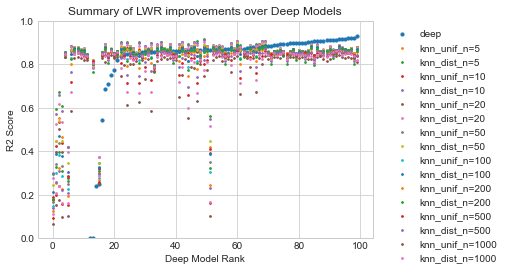

In [13]:
#take 1 is a scatter plot - lets, for each dataset
#graph our deep models by rank - plot - then overlay our knn moels
#plot points

deep_set = scores_df[scores_df["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df[scores_df["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot.png", bbox_inches='tight')
logging.getLogger().info("Wrote Summary Graph")

In [14]:
scores_df["n_features"] = [deep_models[i].n_features for i in scores_df["model_num"]] 

In [15]:
from matplotlib.colors import Colormap
import seaborn as sns #heatmap of features - pls model - score
class nlcmap(Colormap):
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self.transformed_levels = np.linspace(self.levmin, self.levmax, #uniform spacing along levels (colour segments)
             len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self.transformed_levels)
        return self.cmap((yi-self.levmin) / (self.levmax-self.levmin), alpha)
    
levels = np.concatenate((
    [0, 1],
    [0.6,0.8,0.9,0.95,0.98]
    ))

levels = levels[levels <= 1]
levels.sort()
cmap_nonlin = nlcmap(plt.cm.YlGnBu, levels)


In [16]:
scores_df_base = scores_df[scores_df["predictor"]=='deep']
scores_df_dist = scores_df[scores_df["predictor"].str.contains('dist')]   #val_eq_list(scores_df["predictor"],'dist')] #np.logical_or(scores_df["predictor"]=="deep",'dist' in scores_df["predictor"])]
scores_df_unif = scores_df[scores_df["predictor"].str.contains('unif')] 

In [17]:
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

C:\Users\huonf\AppData\Local\Temp\ipykernel_16412\3055751756.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(sc,label="R2 Score")


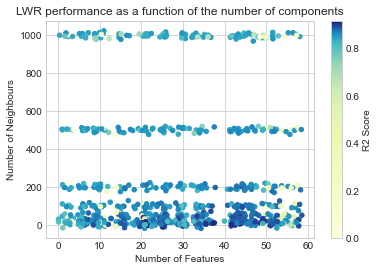

In [18]:
subset = scores_df_dist[["predictor","n_features","R2"]]
#print(subset)
subset = subset[np.logical_not(subset["predictor"]=="deep")]
trans = subset["predictor"].transform(lambda x: int(x.replace("knn_dist_n=",""))).tolist()
subset.loc[:,"predictor"]=trans
subset=subset.sort_values("predictor",ascending=False)

fig, ax = plt.subplots()
sc = ax.scatter(x=rand_jitter(subset["n_features"]), y=rand_jitter(subset["predictor"]), s=20,c=subset["R2"],cmap=cmap_nonlin,vmin=0)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Number of Neighbours")

cbar = fig.colorbar(sc,label="R2 Score")

ax.set_title("LWR performance as a function of the number of components")
plt.savefig(log_dir/f"heat_scatter.png", bbox_inches='tight')



C:\Users\huonf\AppData\Local\Temp\ipykernel_16412\4185436614.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(sc,label="R2 Score")


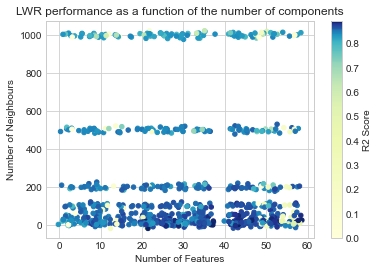

In [19]:
subset = scores_df_unif[["predictor","n_features","R2"]]
#print(subset)
subset = subset[np.logical_not(subset["predictor"]=="deep")]
trans = subset["predictor"].transform(lambda x: int(x.replace("knn_unif_n=",""))).tolist()
subset.loc[:,"predictor"]=trans
subset=subset.sort_values("predictor",ascending=False)

fig, ax = plt.subplots()
sc = ax.scatter(x=rand_jitter(subset["n_features"]), y=rand_jitter(subset["predictor"]), s=20,c=subset["R2"],cmap=cmap_nonlin,vmin=0)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Number of Neighbours")

cbar = fig.colorbar(sc,label="R2 Score")

ax.set_title("LWR performance as a function of the number of components")
plt.savefig(log_dir/f"heat_scatter.png", bbox_inches='tight')



Wrote Summary Graph'


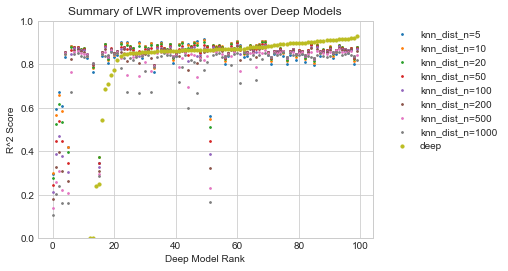

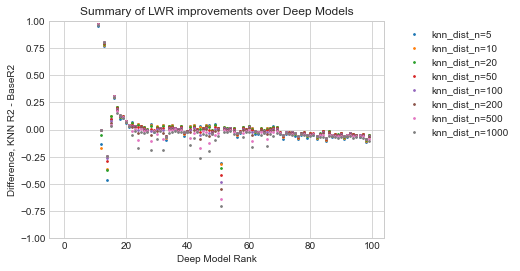

In [20]:
fig, ax = plt.subplots()
knn_models = scores_df_dist["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df_dist[scores_df_dist["predictor"]==knn_model]
    s=3
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

ax.scatter(x=order_models(scores_df_base["model_num"].tolist()), y=scores_df_base["R2"], s=10, label='deep')


#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot_dist.png", bbox_inches='tight')
logging.getLogger().info("Wrote Summary Graph")

fig, ax = plt.subplots()
knn_models = scores_df_dist["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df_dist[scores_df_dist["predictor"]==knn_model]
    s=3
    y1 = subset["R2"].to_numpy() - scores_df_base["R2"].to_numpy()
    
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=y1, s=s, label=knn_model)

ax.set_ylim(-1,1)

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("Difference, KNN R2 - BaseR2")
ax.set_xlabel("Deep Model Rank")

ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"improve_plot_dist.png", bbox_inches='tight')

Wrote Summary Graph'


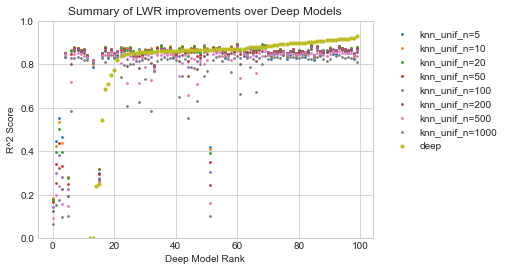

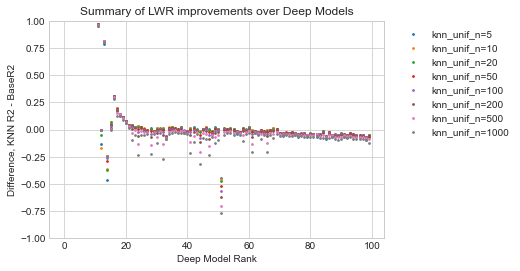

In [21]:
fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df_unif["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df_unif[scores_df_unif["predictor"]==knn_model]
    s=3
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

ax.scatter(x=order_models(scores_df_base["model_num"].tolist()), y=scores_df_base["R2"], s=10, label='deep')


#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot_unif.png", bbox_inches='tight')
logging.getLogger().info("Wrote Summary Graph")

fig, ax = plt.subplots()
knn_models = scores_df_unif["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df_unif[scores_df_unif["predictor"]==knn_model]
    s=3
    y1 = subset["R2"].to_numpy() - scores_df_base["R2"].to_numpy()
    
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=y1, s=s, label=knn_model)

ax.set_ylim(-1,1)

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("Difference, KNN R2 - BaseR2")
ax.set_xlabel("Deep Model Rank")

ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"improve_plot_unif.png", bbox_inches='tight')


In [22]:
import seaborn as sns
from matplotlib.colors import Colormap
class nlcmap(object):
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self.transformed_levels = np.linspace(self.levmin, self.levmax, #uniform spacing along levels (colour segments)
             len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self.transformed_levels)
        return self.cmap((yi-self.levmin) / (self.levmax-self.levmin), alpha)
    
levels = np.concatenate((
    [0, 1],
    [0.6,0.8,0.9,0.95,0.98]
    ))

levels = levels[levels <= 1]
levels.sort()
print(levels)
cmap_nonlin = nlcmap(plt.cm.YlGnBu, levels) 

[0.   0.6  0.8  0.9  0.95 0.98 1.  ]


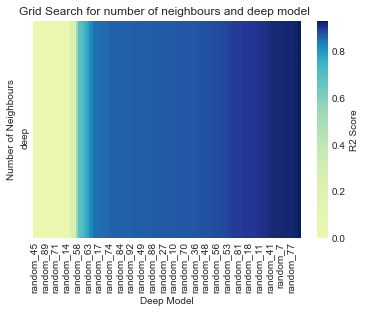

In [23]:
subset = scores_df_base[["model_num",'predictor' ,"R2"]]
#subset = subset.sort_values('model_num', key=order_models)
#trans = subset["predictor"].transform(lambda x: (x.replace("knn_dist_n=",""))).tolist()
#subset.loc[:,"predictor"]=trans

#trans = subset["model_num"].transform(lambda x: int(x.replace("random_",""))).tolist()
#subset.loc[:,"model_num"]=trans

#subset=subset.sort_values("model_num",ascending=False)
wide = subset.pivot(index = "predictor",columns= "model_num",values="R2")
wide = wide.sort_index(axis=1,key=order_models)

ax = sns.heatmap(wide, linewidth=0.0,vmin=0,center=0,cbar_kws={'label':"R2 Score"},cmap=cmap_nonlin)

ax.set_title("Grid Search for number of neighbours and deep model ")
ax.set_xlabel("Deep Model")
ax.set_ylabel("Number of Neighbours")

plt.savefig(log_dir/"pls_heatmap.png", bbox_inches='tight')


Text(37.5, 0.5, 'Number of Neighbours')

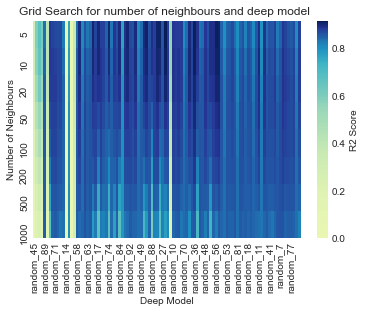

In [24]:
# heat map for distance based knn and deep model

subset = scores_df_dist[["model_num","predictor","R2"]]
subset = subset.sort_values('model_num', key=order_models)

trans = subset["predictor"].transform(lambda x: int(x.replace("knn_dist_n=",""))).tolist()
subset.loc[:,"predictor"]=trans

#trans = subset["model_num"].transform(lambda x: int(x.replace("random_",""))).tolist()
#subset.loc[:,"model_num"]=trans

#subset=subset.sort_values("model_num",ascending=False)
wide = subset.pivot(index = "predictor",columns= "model_num",values="R2")
wide = wide.sort_index(axis=1,key=order_models)

ax = sns.heatmap(wide, linewidth=0.0,vmin=0,center=0,cbar_kws={'label':"R2 Score"},cmap=cmap_nonlin)

ax.set_title("Grid Search for number of neighbours and deep model ")
ax.set_xlabel("Deep Model")
ax.set_ylabel("Number of Neighbours")

#plt.savefig(log_dir/"pls_heatmap.png", bbox_inches='tight')

Text(37.5, 0.5, 'Number of Neighbours')

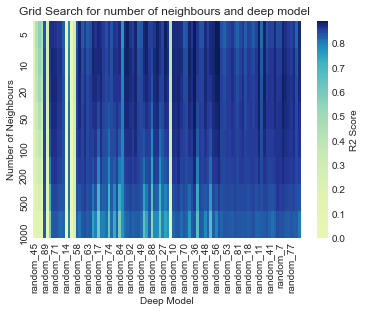

In [25]:
# heat map for uniform  based knn and deep model

subset = scores_df_unif[["model_num","predictor","R2"]]
subset = subset.sort_values('model_num', key=order_models)

trans = subset["predictor"].transform(lambda x: int(x.replace("knn_unif_n=",""))).tolist()
subset.loc[:,"predictor"]=trans

#trans = subset["model_num"].transform(lambda x: int(x.replace("random_",""))).tolist()
#subset.loc[:,"model_num"]=trans

#subset=subset.sort_values("model_num",ascending=False)
wide = subset.pivot(index = "predictor",columns= "model_num",values="R2")
wide = wide.sort_index(axis=1,key=order_models)

ax = sns.heatmap(wide, linewidth=0.0,vmin=0,center=0,cbar_kws={'label':"R2 Score"},cmap=cmap_nonlin)

ax.set_title("Grid Search for number of neighbours and deep model ")
ax.set_xlabel("Deep Model")
ax.set_ylabel("Number of Neighbours")

#plt.savefig(log_dir/"pls_heatmap.png", bbox_inches='tight')


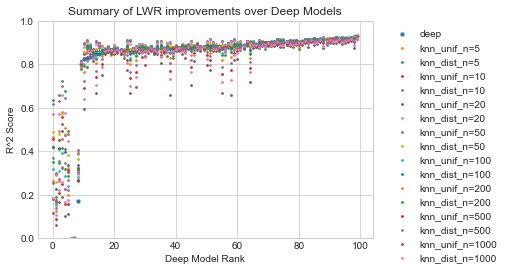

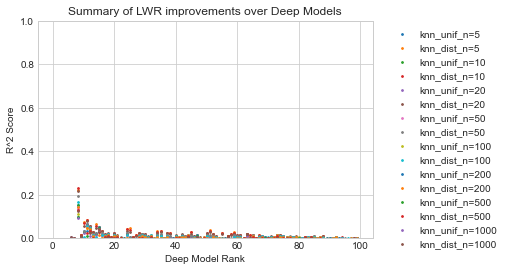

In [26]:
#graph our deep models by rank on final set - plot - then overlay our knn moels

deep_set = scores_df_final[scores_df_final["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df_final["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df_final[scores_df_final["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot_final.png", bbox_inches='tight')

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df_final["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df_final[scores_df_final["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        pass
    else:
        y1 = subset["R2"].to_numpy() - scores_df_final[scores_df_final["predictor"]=='deep']["R2"].to_numpy()
        ax.scatter(x=order_models(subset["model_num"].tolist()), y=y1, s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"improvement_plot_final.png", bbox_inches='tight')